<a href="https://colab.research.google.com/github/arabporr/Projects/blob/main/Data_Mining_Final/Data_Mining_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining Final Project
### Reza Arabpour - 610397136

  The task description is available [here](https://drive.google.com/file/d/1YlwLaVlDq4CFV77Ut1sLhv1cT68hOfFk/view?usp=sharing) and the dataset [here.](https://www.muratkoklu.com/datasets/Grapevine_Leaves_Image_Dataset.zip)

Long story short, this project is about classifying grape leaves in to 5 classes besed on theis leaf scanned images. 

## Environment Initialization

In [ ]:
#Loading General Tools and Libraries
import os
import random
import shutil
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
plt.style.use('ggplot')

## Data Loading

### Data Downloading

In [ ]:
#Loading Dataset
!rm -rf Grapevine_Leaves_Image_Dataset*
!rm -rf Test_Data
!wget https://www.muratkoklu.com/datasets/Grapevine_Leaves_Image_Dataset.zip
!unzip -q Grapevine_Leaves_Image_Dataset.zip 
!rm Grapevine_Leaves_Image_Dataset.zip
!ls -lh

--2022-08-06 06:26:31--  https://www.muratkoklu.com/datasets/Grapevine_Leaves_Image_Dataset.zip
Resolving www.muratkoklu.com (www.muratkoklu.com)... 185.179.25.150
Connecting to www.muratkoklu.com (www.muratkoklu.com)|185.179.25.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113862245 (109M) [application/zip]
Saving to: ‘Grapevine_Leaves_Image_Dataset.zip’

Grapevine_Leaves_Im 100%[===================>] 108.59M  20.7MB/s    in 6.3s    

2022-08-06 06:26:38 (17.4 MB/s) - ‘Grapevine_Leaves_Image_Dataset.zip’ saved [113862245/113862245]

total 8.0K
drwxr-xr-x 7 root root 4.0K Feb 11 17:53 Grapevine_Leaves_Image_Dataset
drwxr-xr-x 1 root root 4.0K Aug  3 20:21 sample_data


### Select and Move 20% of Data for OOS (Out Of Sample) Testing

In [ ]:
Species = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"]
OriginalDataPath = "Grapevine_Leaves_Image_Dataset"
TestDataPath = "Test_Data"
os.mkdir(os.path.join(TestDataPath,""))

for folder_name in Species:
  Percentage = 20/100
  Test_location = os.path.join(TestDataPath,folder_name)
  os.mkdir(Test_location)
  Original_location = os.path.join(OriginalDataPath, folder_name)
  AllImages = os.listdir(Original_location)
  Count = int(Percentage * len(AllImages))
  Selecteds = random.sample(AllImages, Count)
  for file in Selecteds:
    shutil.move(os.path.join(Original_location,file), Test_location)


### Datasets Loading (Train, Validation, and Test)

In [ ]:
image_size = (256,256)
batch_size = 32
validation_split = 0.2
seed = 199

train_data = tf.keras.utils.image_dataset_from_directory(
    'Grapevine_Leaves_Image_Dataset',
    class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=validation_split,
    subset="training"
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    'Grapevine_Leaves_Image_Dataset',
    class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=validation_split,
    subset="validation"
)

test_data = tf.keras.utils.image_dataset_from_directory(
    'Test_Data',
    class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
    image_size=image_size,
    batch_size=100,
    shuffle=False)


Found 400 files belonging to 5 classes.
Using 320 files for training.
Found 400 files belonging to 5 classes.
Using 80 files for validation.
Found 100 files belonging to 5 classes.


## Data Augmentation

### Color Transformation

In [ ]:
train_data2 = train_data.map(lambda x, y: (255-x, y))
validation_data2 = validation_data.map(lambda x, y: (255-x, y))
test_data2 = test_data.map(lambda x, y: (255-x, y))

### Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0)
])

augmented_train_data = train_data2
for i in range(4):
  augmented_train_data = augmented_train_data.concatenate(train_data2.map(lambda x, y: (data_augmentation(x, training=True), y)))

### Showing a random sample

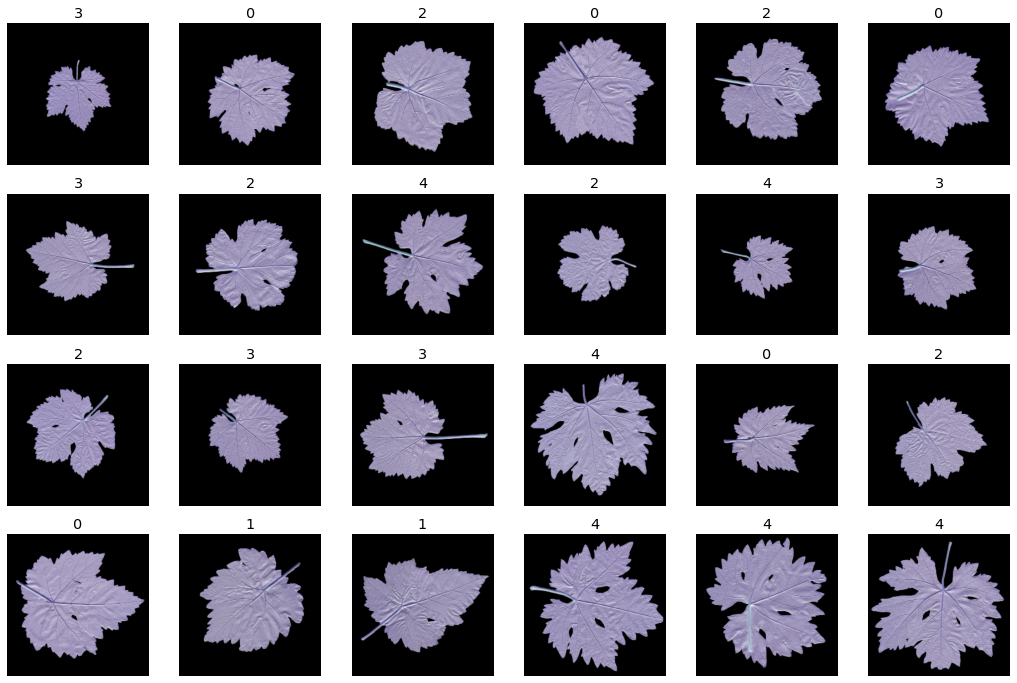

In [ ]:
plt.figure(figsize=(18, 12))
for images, labels in augmented_train_data.take(1):
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## My own Convolutional neural network Model

### Model Architecture Define

In [ ]:
MyOwnModel = keras.models.Sequential([
    layers.RandomRotation(0.1, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.Conv2D(16, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(256, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2,2),
    layers.Conv2D(512, (3, 3), activation='relu'), 
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])
MyOwnModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)     

### Model Creation and Training

In [ ]:
MyOwnModel.compile(
    optimizer=keras.optimizers.Adam(2*1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
epochs = 200
history_myown = MyOwnModel.fit(
    train_data2, epochs=epochs,
    validation_data=validation_data2)
MyOwnModel.save('MyOwnModel.h5')

Epoch 1/200
10/10 [==============================] - 16s 131ms/step - loss: 2.9622 - accuracy: 0.1875 - val_loss: 1.9348 - val_accuracy: 0.1625
Epoch 2/200
10/10 [==============================] - 2s 103ms/step - loss: 1.7455 - accuracy: 0.2438 - val_loss: 1.6958 - val_accuracy: 0.2000
Epoch 3/200
10/10 [==============================] - 2s 110ms/step - loss: 1.6269 - accuracy: 0.2719 - val_loss: 1.7164 - val_accuracy: 0.2000
Epoch 4/200
10/10 [==============================] - 2s 142ms/step - loss: 1.5963 - accuracy: 0.2594 - val_loss: 1.5781 - val_accuracy: 0.3125
Epoch 5/200
10/10 [==============================] - 2s 108ms/step - loss: 1.5438 - accuracy: 0.3031 - val_loss: 1.6837 - val_accuracy: 0.2250
Epoch 6/200
10/10 [==============================] - 2s 110ms/step - loss: 1.5902 - accuracy: 0.2500 - val_loss: 1.6251 - val_accuracy: 0.3500
Epoch 7/200
10/10 [==============================] - 2s 114ms/step - loss: 1.5815 - accuracy: 0.2781 - val_loss: 1.7003 - val_accuracy: 0.262

### Accuracy Curve

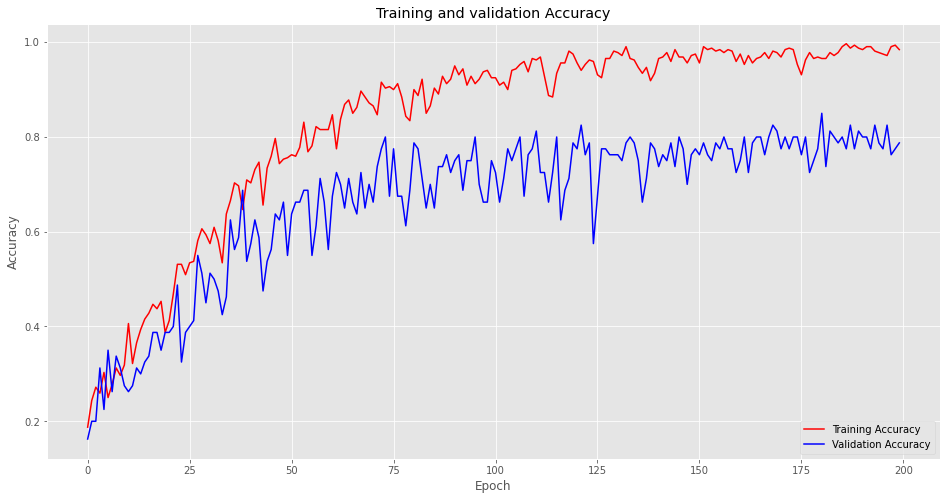

In [ ]:
MyOwnModel_acc=history_myown.history['accuracy']
MyOwnModel_val_acc=history_myown.history['val_accuracy']
MyOwnModel_loss=history_myown.history['loss']
MyOwnModel_val_loss=history_myown.history['val_loss']
epochs=range(len(MyOwnModel_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, MyOwnModel_acc, 'r', label="Training Accuracy")
plt.plot(epochs, MyOwnModel_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
plt.show()

### Loss Curve

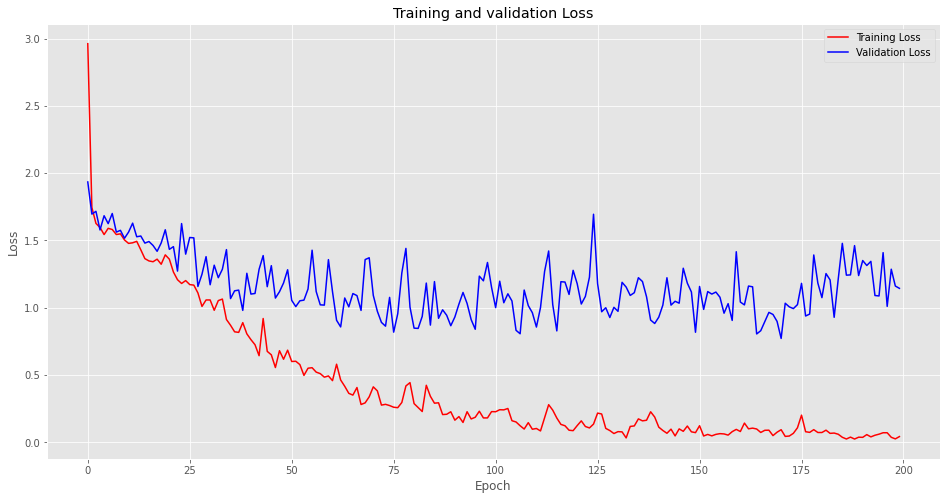

In [ ]:
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, MyOwnModel_loss, 'r', label="Training Loss")
plt.plot(epochs, MyOwnModel_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

### Model Performance Evaluation on Test Data 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
result = MyOwnModel.predict(test_data2)
y_test = np.concatenate([y for x, y in test_data2], axis=0)
MyOwnModel_y_predict = np.array([i.argmax() for i in result])

MyOwnModel_cm = confusion_matrix(y_test, MyOwnModel_y_predict)
MyOwnModel_ac = accuracy_score(y_test,MyOwnModel_y_predict)

print("confusion matrix on test data :\n",MyOwnModel_cm)
print("accuracy score on test data:\n",MyOwnModel_ac)

print(classification_report(y_test, MyOwnModel_y_predict))

confusion matrix on test data :
 [[14  3  0  3  0]
 [ 2 15  0  2  1]
 [ 1  1 14  3  1]
 [ 0  2  0 17  1]
 [ 0  0  0  0 20]]
accuracy score on test data:
 0.8
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.71      0.75      0.73        20
           2       1.00      0.70      0.82        20
           3       0.68      0.85      0.76        20
           4       0.87      1.00      0.93        20

    accuracy                           0.80       100
   macro avg       0.82      0.80      0.80       100
weighted avg       0.82      0.80      0.80       100



## Pre-Trained Models

### Training Parameters


In [ ]:
pre_trained_data = train_data2
pre_trained_epochs = 30
pre_trained_validation_data = validation_data2

### Xception

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=image_size + (3,))
pretrained_model.trainable = False
Xception_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
Xception_Model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_2 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            

#### Model Creation and Training

In [ ]:
Xception_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
Xception_Model_History = Xception_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

Epoch 1/30
10/10 [==============================] - 11s 556ms/step - loss: 32.7070 - accuracy: 0.2656 - val_loss: 14.0847 - val_accuracy: 0.2250
Epoch 2/30
10/10 [==============================] - 4s 273ms/step - loss: 11.0246 - accuracy: 0.2562 - val_loss: 9.9999 - val_accuracy: 0.2375
Epoch 3/30
10/10 [==============================] - 4s 336ms/step - loss: 6.7872 - accuracy: 0.3187 - val_loss: 6.5402 - val_accuracy: 0.2500
Epoch 4/30
10/10 [==============================] - 4s 270ms/step - loss: 8.2434 - accuracy: 0.3063 - val_loss: 5.8254 - val_accuracy: 0.3375
Epoch 5/30
10/10 [==============================] - 4s 276ms/step - loss: 5.6012 - accuracy: 0.3344 - val_loss: 5.1424 - val_accuracy: 0.2250
Epoch 6/30
10/10 [==============================] - 5s 275ms/step - loss: 4.4893 - accuracy: 0.3094 - val_loss: 3.0599 - val_accuracy: 0.2625
Epoch 7/30
10/10 [==============================] - 4s 277ms/step - loss: 3.9858 - accuracy: 0.3812 - val_loss: 3.1409 - val_accuracy: 0.3000
Ep

#### Accuracy and Loss Curves

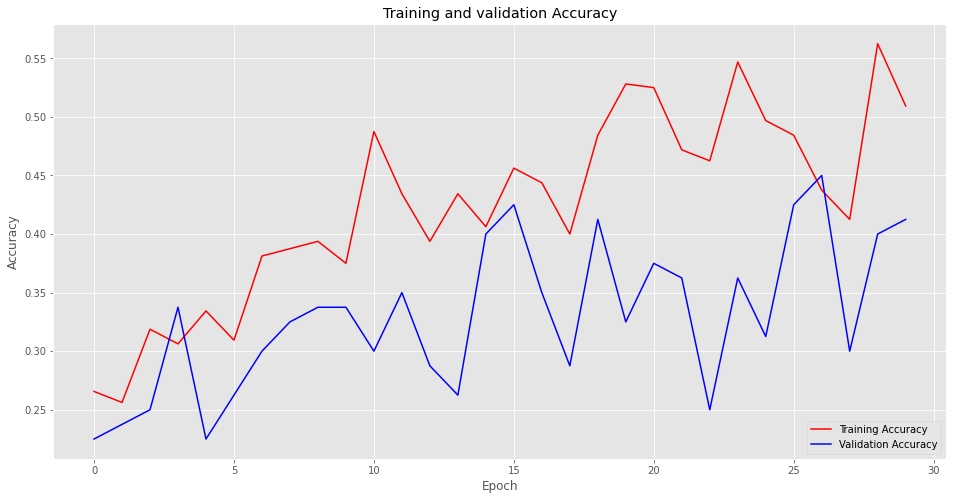

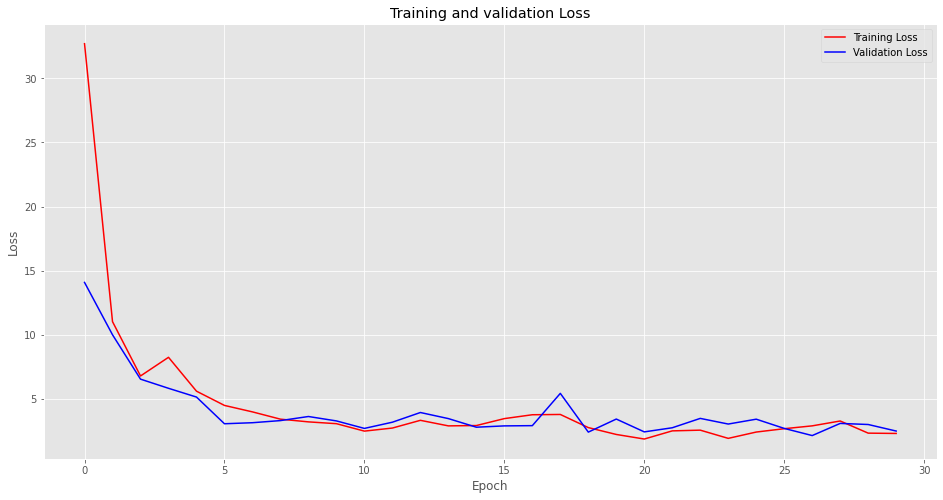

In [ ]:
Xception_Model_acc = Xception_Model_History.history['accuracy']
Xception_Model_val_acc = Xception_Model_History.history['val_accuracy']
Xception_Model_loss = Xception_Model_History.history['loss']
Xception_Model_val_loss = Xception_Model_History.history['val_loss']
epochs = range(len(Xception_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, Xception_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, Xception_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, Xception_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, Xception_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
result = Xception_Model.predict(test_data2)
Xception_Model_y_predict = np.array([i.argmax() for i in result])

Xception_Model_cm = confusion_matrix(y_test, Xception_Model_y_predict)
Xception_Model_ac = accuracy_score(y_test,Xception_Model_y_predict)

print("confusion matrix on test data :\n",Xception_Model_cm)
print("accuracy score on test data:\n",Xception_Model_ac)

print(classification_report(y_test, Xception_Model_y_predict))

confusion matrix on test data :
 [[ 6  2  4  4  4]
 [ 1  7  1  4  7]
 [ 0  3 10  1  6]
 [ 0  1  4  8  7]
 [ 1  0  1  3 15]]
accuracy score on test data:
 0.46
              precision    recall  f1-score   support

           0       0.75      0.30      0.43        20
           1       0.54      0.35      0.42        20
           2       0.50      0.50      0.50        20
           3       0.40      0.40      0.40        20
           4       0.38      0.75      0.51        20

    accuracy                           0.46       100
   macro avg       0.51      0.46      0.45       100
weighted avg       0.51      0.46      0.45       100



### VGG16

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
    classifier_activation="softmax",
)
pretrained_model.trainable = False
VGG16_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
VGG16_Model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_3 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             

#### Model Creation and Training

In [ ]:
VGG16_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
VGG16_Model_History = VGG16_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

Epoch 1/30
10/10 [==============================] - 11s 522ms/step - loss: 6.7587 - accuracy: 0.3063 - val_loss: 4.6152 - val_accuracy: 0.3125
Epoch 2/30
10/10 [==============================] - 4s 304ms/step - loss: 2.7371 - accuracy: 0.4938 - val_loss: 3.3789 - val_accuracy: 0.4500
Epoch 3/30
10/10 [==============================] - 5s 302ms/step - loss: 1.6303 - accuracy: 0.6000 - val_loss: 2.0212 - val_accuracy: 0.5625
Epoch 4/30
10/10 [==============================] - 4s 318ms/step - loss: 1.0883 - accuracy: 0.7000 - val_loss: 1.4958 - val_accuracy: 0.6250
Epoch 5/30
10/10 [==============================] - 5s 303ms/step - loss: 0.8151 - accuracy: 0.7437 - val_loss: 1.1054 - val_accuracy: 0.7000
Epoch 6/30
10/10 [==============================] - 4s 318ms/step - loss: 0.7253 - accuracy: 0.7688 - val_loss: 1.1249 - val_accuracy: 0.7250
Epoch 7/30
10/10 [==============================] - 5s 303ms/step - loss: 0.5306 - accuracy: 0.8062 - val_loss: 1.0347 - val_accuracy: 0.6625
Epoch

#### Accuracy and Loss Curves

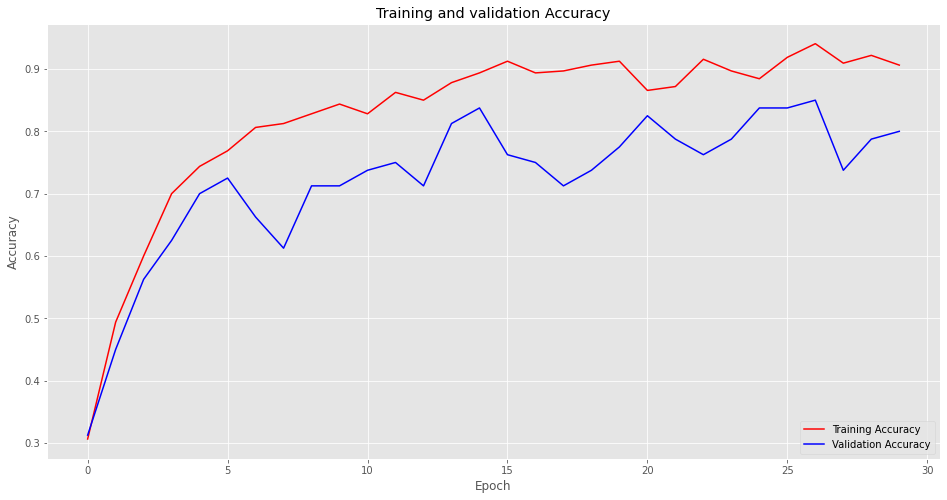

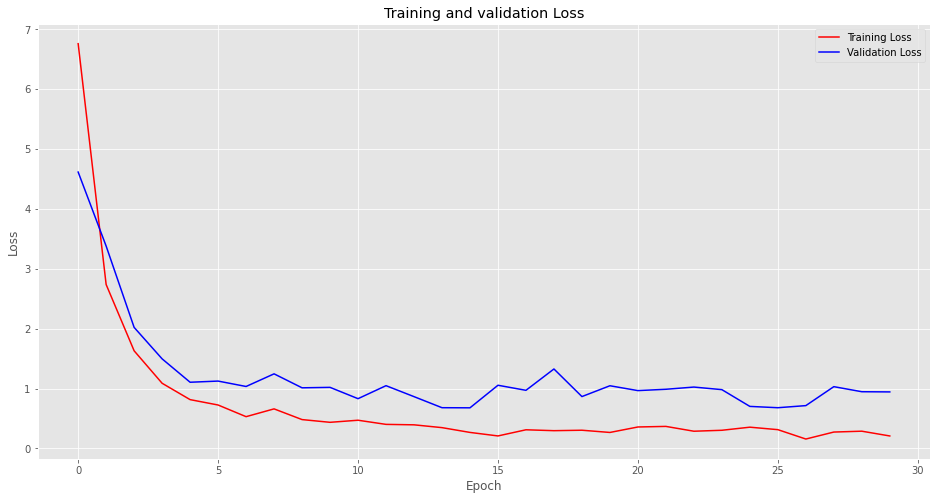

In [ ]:
VGG16_Model_acc = VGG16_Model_History.history['accuracy']
VGG16_Model_val_acc = VGG16_Model_History.history['val_accuracy']
VGG16_Model_loss = VGG16_Model_History.history['loss']
VGG16_Model_val_loss = VGG16_Model_History.history['val_loss']
epochs = range(len(VGG16_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, VGG16_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, VGG16_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, VGG16_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, VGG16_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
result = VGG16_Model.predict(test_data2)
VGG16_Model_y_predict = np.array([i.argmax() for i in result])

VGG16_Model_cm = confusion_matrix(y_test, VGG16_Model_y_predict)
VGG16_Model_ac = accuracy_score(y_test,VGG16_Model_y_predict)

print("confusion matrix on test data :\n",VGG16_Model_cm)
print("accuracy score on test data:\n",VGG16_Model_ac)

print(classification_report(y_test, VGG16_Model_y_predict))

confusion matrix on test data :
 [[15  5  0  0  0]
 [ 0 17  2  0  1]
 [ 0  2 17  1  0]
 [ 2  0  2 16  0]
 [ 1  0  0  0 19]]
accuracy score on test data:
 0.84
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.71      0.85      0.77        20
           2       0.81      0.85      0.83        20
           3       0.94      0.80      0.86        20
           4       0.95      0.95      0.95        20

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



### VGG19

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
    classifier_activation="softmax",
)
pretrained_model.trainable = False
VGG19_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
VGG19_Model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_4 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_9 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                      

#### Model Creation and Training

In [ ]:
VGG19_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
VGG19_Model_History = VGG19_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

Epoch 1/30
10/10 [==============================] - 6s 360ms/step - loss: 5.6395 - accuracy: 0.2562 - val_loss: 2.7137 - val_accuracy: 0.4125
Epoch 2/30
10/10 [==============================] - 4s 302ms/step - loss: 1.5243 - accuracy: 0.4906 - val_loss: 1.7020 - val_accuracy: 0.5125
Epoch 3/30
10/10 [==============================] - 4s 307ms/step - loss: 1.0576 - accuracy: 0.6313 - val_loss: 1.4186 - val_accuracy: 0.5750
Epoch 4/30
10/10 [==============================] - 4s 306ms/step - loss: 0.9200 - accuracy: 0.6938 - val_loss: 1.0202 - val_accuracy: 0.6125
Epoch 5/30
10/10 [==============================] - 5s 307ms/step - loss: 0.6182 - accuracy: 0.7875 - val_loss: 0.9814 - val_accuracy: 0.7125
Epoch 6/30
10/10 [==============================] - 4s 306ms/step - loss: 0.5287 - accuracy: 0.8188 - val_loss: 0.9446 - val_accuracy: 0.7875
Epoch 7/30
10/10 [==============================] - 5s 306ms/step - loss: 0.5355 - accuracy: 0.7969 - val_loss: 0.8234 - val_accuracy: 0.7625
Epoch 

#### Accuracy and Loss Curves

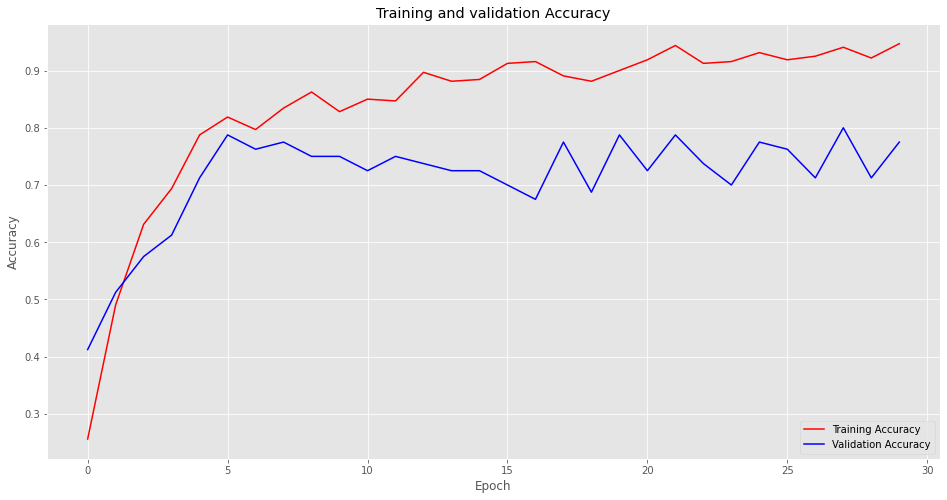

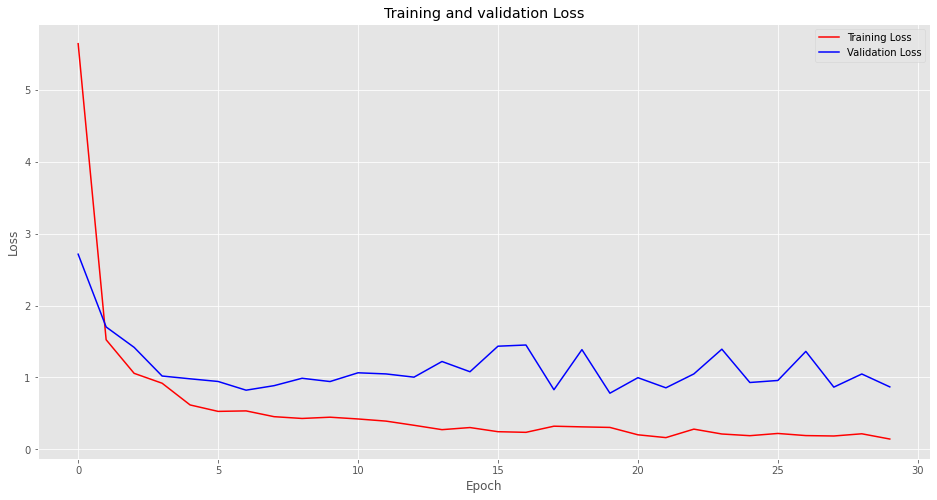

In [ ]:
VGG19_Model_acc = VGG19_Model_History.history['accuracy']
VGG19_Model_val_acc = VGG19_Model_History.history['val_accuracy']
VGG19_Model_loss = VGG19_Model_History.history['loss']
VGG19_Model_val_loss = VGG19_Model_History.history['val_loss']
epochs = range(len(VGG19_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, VGG19_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, VGG19_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, VGG19_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, VGG19_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
result = VGG19_Model.predict(test_data2)
VGG19_Model_y_predict = np.array([i.argmax() for i in result])

VGG19_Model_cm = confusion_matrix(y_test, VGG19_Model_y_predict)
VGG19_Model_ac = accuracy_score(y_test,VGG19_Model_y_predict)

print("confusion matrix on test data :\n",VGG19_Model_cm)
print("accuracy score on test data:\n",VGG19_Model_ac)

print(classification_report(y_test, VGG19_Model_y_predict))

confusion matrix on test data :
 [[17  3  0  0  0]
 [ 1 16  3  0  0]
 [ 0  2 18  0  0]
 [ 2  0  3 15  0]
 [ 2  1  2  0 15]]
accuracy score on test data:
 0.81
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.73      0.80      0.76        20
           2       0.69      0.90      0.78        20
           3       1.00      0.75      0.86        20
           4       1.00      0.75      0.86        20

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



### ResNet50

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
)
pretrained_model.trainable = False
ResNet50_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
ResNet50_Model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_5 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_10 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_11 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            

#### Model Creation and Training

In [ ]:
ResNet50_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
ResNet50_Model_History = ResNet50_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

Epoch 1/30
10/10 [==============================] - 10s 398ms/step - loss: 4.5722 - accuracy: 0.2531 - val_loss: 2.4291 - val_accuracy: 0.3875
Epoch 2/30
10/10 [==============================] - 4s 230ms/step - loss: 1.6234 - accuracy: 0.5031 - val_loss: 1.2514 - val_accuracy: 0.4625
Epoch 3/30
10/10 [==============================] - 3s 234ms/step - loss: 0.8899 - accuracy: 0.6875 - val_loss: 1.1584 - val_accuracy: 0.5875
Epoch 4/30
10/10 [==============================] - 3s 235ms/step - loss: 0.6053 - accuracy: 0.7688 - val_loss: 0.8434 - val_accuracy: 0.7000
Epoch 5/30
10/10 [==============================] - 3s 234ms/step - loss: 0.5910 - accuracy: 0.7906 - val_loss: 0.7719 - val_accuracy: 0.7125
Epoch 6/30
10/10 [==============================] - 4s 250ms/step - loss: 0.4581 - accuracy: 0.8344 - val_loss: 1.0123 - val_accuracy: 0.6375
Epoch 7/30
10/10 [==============================] - 3s 232ms/step - loss: 0.4031 - accuracy: 0.8469 - val_loss: 0.7058 - val_accuracy: 0.7750
Epoch

#### Accuracy and Loss Curves

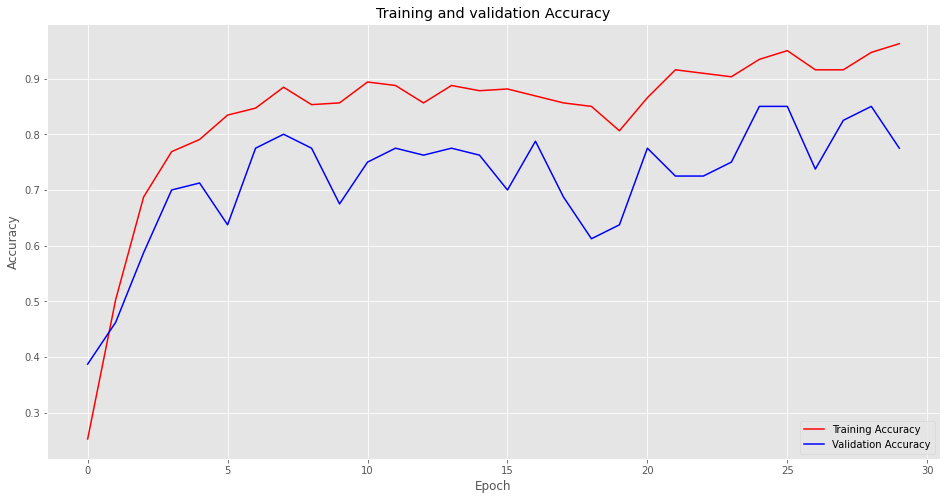

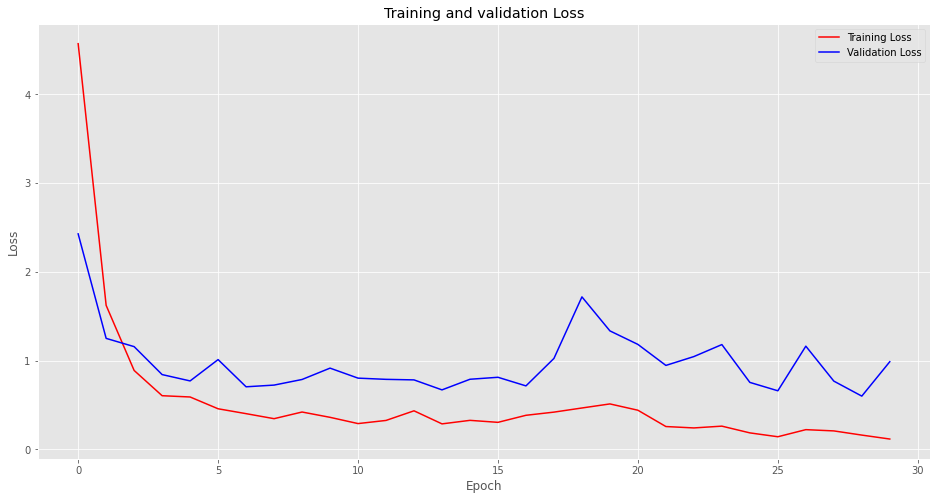

In [ ]:
ResNet50_Model_acc = ResNet50_Model_History.history['accuracy']
ResNet50_Model_val_acc = ResNet50_Model_History.history['val_accuracy']
ResNet50_Model_loss = ResNet50_Model_History.history['loss']
ResNet50_Model_val_loss = ResNet50_Model_History.history['val_loss']
epochs = range(len(ResNet50_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet50_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, ResNet50_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet50_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, ResNet50_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
result = ResNet50_Model.predict(test_data2)
ResNet50_Model_y_predict = np.array([i.argmax() for i in result])

ResNet50_Model_cm = confusion_matrix(y_test, ResNet50_Model_y_predict)
ResNet50_Model_ac = accuracy_score(y_test,ResNet50_Model_y_predict)

print("confusion matrix on test data :\n",ResNet50_Model_cm)
print("accuracy score on test data:\n",ResNet50_Model_ac)

print(classification_report(y_test, ResNet50_Model_y_predict))

confusion matrix on test data :
 [[18  0  1  0  1]
 [ 4 13  2  0  1]
 [ 2  0 17  1  0]
 [ 2  0  1 14  3]
 [ 1  0  0  0 19]]
accuracy score on test data:
 0.81
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        20
           1       1.00      0.65      0.79        20
           2       0.81      0.85      0.83        20
           3       0.93      0.70      0.80        20
           4       0.79      0.95      0.86        20

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



### ResNet101

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
)
pretrained_model.trainable = False
ResNet101_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
ResNet101_Model.summary()

171458560/171446536 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_6 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_12 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_13 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 resnet101 (Functional)      (None, 8, 8, 2048)        42658176  
                                                                 
 flatten_5 (Flatten)         (None, 131072)          

#### Model Creation and Training

In [ ]:
ResNet101_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
ResNet101_Model_History = ResNet101_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

Epoch 1/30
10/10 [==============================] - 13s 548ms/step - loss: 5.6860 - accuracy: 0.2875 - val_loss: 1.3425 - val_accuracy: 0.5625
Epoch 2/30
10/10 [==============================] - 5s 366ms/step - loss: 1.1920 - accuracy: 0.5437 - val_loss: 1.2854 - val_accuracy: 0.5750
Epoch 3/30
10/10 [==============================] - 5s 360ms/step - loss: 0.8699 - accuracy: 0.6812 - val_loss: 1.1470 - val_accuracy: 0.6000
Epoch 4/30
10/10 [==============================] - 5s 412ms/step - loss: 0.7355 - accuracy: 0.7094 - val_loss: 0.8754 - val_accuracy: 0.7750
Epoch 5/30
10/10 [==============================] - 5s 359ms/step - loss: 0.5567 - accuracy: 0.8250 - val_loss: 0.9768 - val_accuracy: 0.6875
Epoch 6/30
10/10 [==============================] - 5s 397ms/step - loss: 0.3602 - accuracy: 0.8531 - val_loss: 1.2088 - val_accuracy: 0.6250
Epoch 7/30
10/10 [==============================] - 5s 360ms/step - loss: 0.3514 - accuracy: 0.8562 - val_loss: 0.7624 - val_accuracy: 0.7500
Epoch

#### Accuracy and Loss Curves

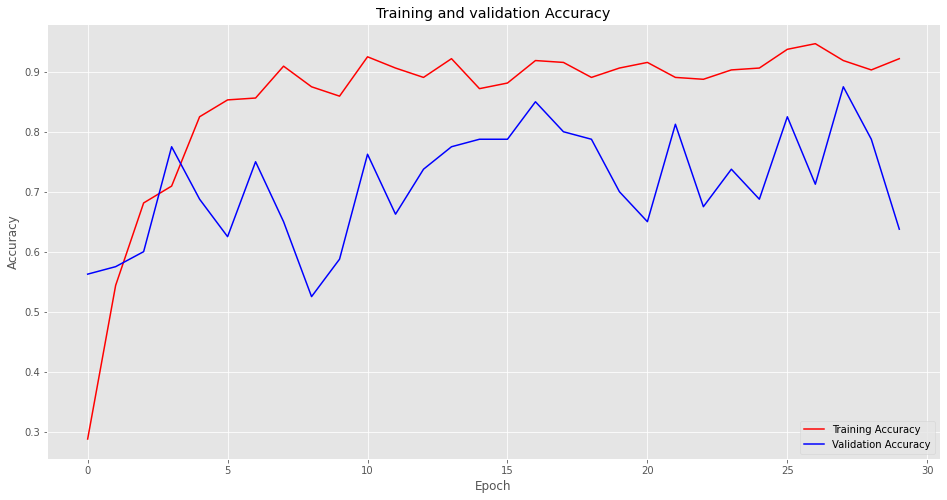

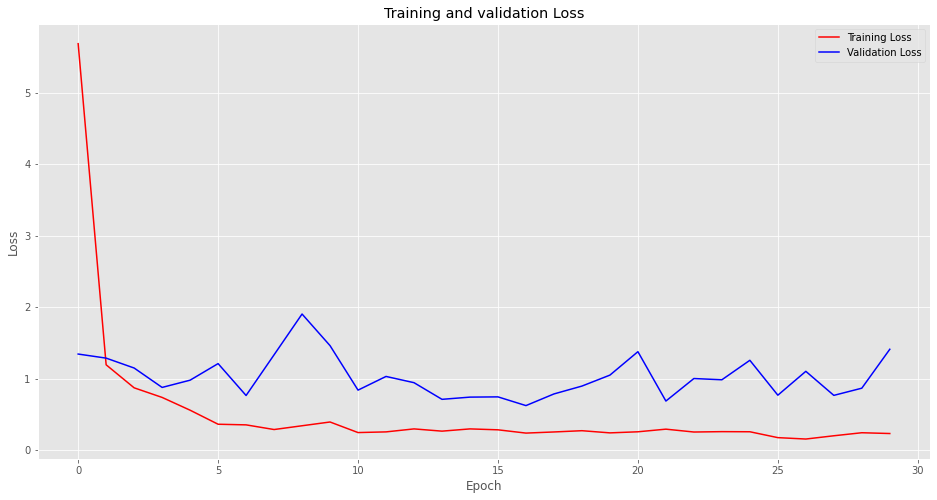

In [ ]:
ResNet101_Model_acc = ResNet101_Model_History.history['accuracy']
ResNet101_Model_val_acc = ResNet101_Model_History.history['val_accuracy']
ResNet101_Model_loss = ResNet101_Model_History.history['loss']
ResNet101_Model_val_loss = ResNet101_Model_History.history['val_loss']
epochs = range(len(ResNet101_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet101_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, ResNet101_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet101_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, ResNet101_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
result = ResNet101_Model.predict(test_data2)
ResNet101_Model_y_predict = np.array([i.argmax() for i in result])

ResNet101_Model_cm = confusion_matrix(y_test, ResNet101_Model_y_predict)
ResNet101_Model_ac = accuracy_score(y_test,ResNet101_Model_y_predict)

print("confusion matrix on test data :\n",ResNet101_Model_cm)
print("accuracy score on test data:\n",ResNet101_Model_ac)

print(classification_report(y_test, ResNet101_Model_y_predict))

confusion matrix on test data :
 [[18  0  0  0  2]
 [ 1 11  3  0  5]
 [ 3  1 14  0  2]
 [ 5  0  0  8  7]
 [ 0  0  0  0 20]]
accuracy score on test data:
 0.71
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        20
           1       0.92      0.55      0.69        20
           2       0.82      0.70      0.76        20
           3       1.00      0.40      0.57        20
           4       0.56      1.00      0.71        20

    accuracy                           0.71       100
   macro avg       0.79      0.71      0.70       100
weighted avg       0.79      0.71      0.70       100



### ResNet152

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
)
pretrained_model.trainable = False
ResNet152_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
ResNet152_Model.summary()

234708992/234698864 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_7 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_6 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_14 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_15 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 8, 8, 2048)        58370944  
                                                                 
 flatten_6 (Flatten)         (None, 131072)          

#### Model Creation and Training

In [ ]:
ResNet152_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
ResNet152_Model_History = ResNet152_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

Epoch 1/30
10/10 [==============================] - 18s 832ms/step - loss: 4.3646 - accuracy: 0.3031 - val_loss: 1.7855 - val_accuracy: 0.4625
Epoch 2/30
10/10 [==============================] - 6s 523ms/step - loss: 1.0501 - accuracy: 0.6062 - val_loss: 1.1214 - val_accuracy: 0.6500
Epoch 3/30
10/10 [==============================] - 6s 510ms/step - loss: 0.8167 - accuracy: 0.7000 - val_loss: 0.8061 - val_accuracy: 0.7500
Epoch 4/30
10/10 [==============================] - 6s 495ms/step - loss: 0.5969 - accuracy: 0.8031 - val_loss: 0.6768 - val_accuracy: 0.7500
Epoch 5/30
10/10 [==============================] - 6s 528ms/step - loss: 0.4771 - accuracy: 0.8250 - val_loss: 0.7281 - val_accuracy: 0.7875
Epoch 6/30
10/10 [==============================] - 6s 500ms/step - loss: 0.4554 - accuracy: 0.8313 - val_loss: 0.7387 - val_accuracy: 0.7500
Epoch 7/30
10/10 [==============================] - 6s 491ms/step - loss: 0.4077 - accuracy: 0.8500 - val_loss: 0.7099 - val_accuracy: 0.7375
Epoch

#### Accuracy and Loss Curves

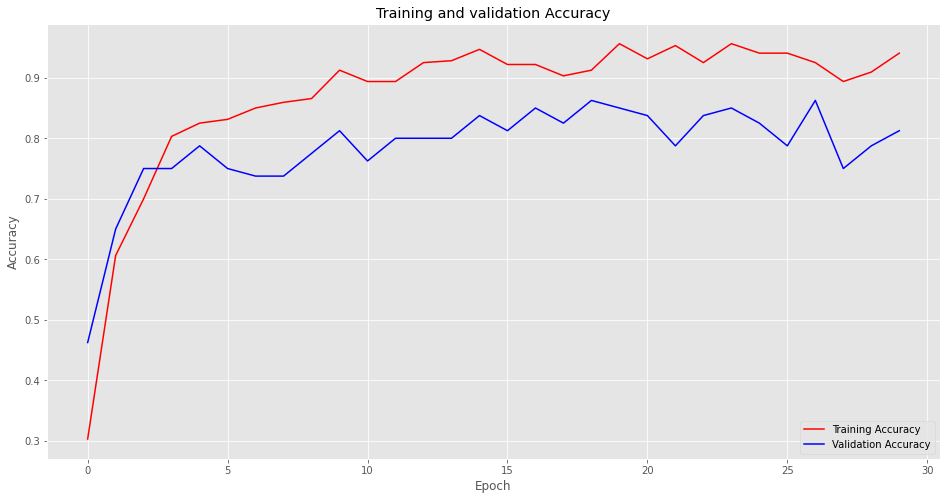

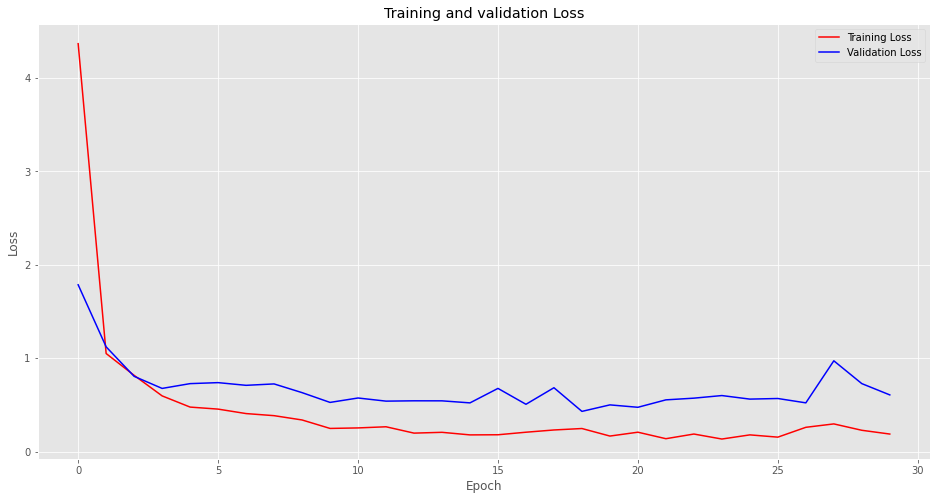

In [ ]:
ResNet152_Model_acc = ResNet152_Model_History.history['accuracy']
ResNet152_Model_val_acc = ResNet152_Model_History.history['val_accuracy']
ResNet152_Model_loss = ResNet152_Model_History.history['loss']
ResNet152_Model_val_loss = ResNet152_Model_History.history['val_loss']
epochs = range(len(ResNet152_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet152_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, ResNet152_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet152_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, ResNet152_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
result = ResNet152_Model.predict(test_data2)
ResNet152_Model_y_predict = np.array([i.argmax() for i in result])

ResNet152_Model_cm = confusion_matrix(y_test, ResNet152_Model_y_predict)
ResNet152_Model_ac = accuracy_score(y_test,ResNet152_Model_y_predict)

print("confusion matrix on test data :\n",ResNet152_Model_cm)
print("accuracy score on test data:\n",ResNet152_Model_ac)

print(classification_report(y_test, ResNet152_Model_y_predict))

confusion matrix on test data :
 [[17  1  1  1  0]
 [ 2 16  0  0  2]
 [ 1  2 15  0  2]
 [ 0  0  1 17  2]
 [ 0  0  1  0 19]]
accuracy score on test data:
 0.84
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        20
           1       0.84      0.80      0.82        20
           2       0.83      0.75      0.79        20
           3       0.94      0.85      0.89        20
           4       0.76      0.95      0.84        20

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



### InceptionV3

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
    classifier_activation="softmax",
)
pretrained_model.trainable = False
InceptionV3_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
InceptionV3_Model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_8 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_7 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_16 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_17 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_7 (Flatten)         (None, 73728)             

#### Model Creation and Training

In [ ]:
InceptionV3_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
InceptionV3_Model_History = InceptionV3_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

Epoch 1/30
10/10 [==============================] - 12s 466ms/step - loss: 54.7331 - accuracy: 0.2062 - val_loss: 37.6085 - val_accuracy: 0.1750
Epoch 2/30
10/10 [==============================] - 3s 170ms/step - loss: 20.3322 - accuracy: 0.2906 - val_loss: 15.3934 - val_accuracy: 0.2625
Epoch 3/30
10/10 [==============================] - 3s 201ms/step - loss: 8.9784 - accuracy: 0.4062 - val_loss: 7.2548 - val_accuracy: 0.3750
Epoch 4/30
10/10 [==============================] - 3s 167ms/step - loss: 7.5964 - accuracy: 0.4281 - val_loss: 6.2427 - val_accuracy: 0.3625
Epoch 5/30
10/10 [==============================] - 4s 186ms/step - loss: 6.3075 - accuracy: 0.3812 - val_loss: 5.4896 - val_accuracy: 0.3750
Epoch 6/30
10/10 [==============================] - 3s 168ms/step - loss: 5.0698 - accuracy: 0.4125 - val_loss: 7.8597 - val_accuracy: 0.2625
Epoch 7/30
10/10 [==============================] - 4s 181ms/step - loss: 4.6160 - accuracy: 0.4062 - val_loss: 5.9567 - val_accuracy: 0.3125
E

#### Accuracy and Loss Curves

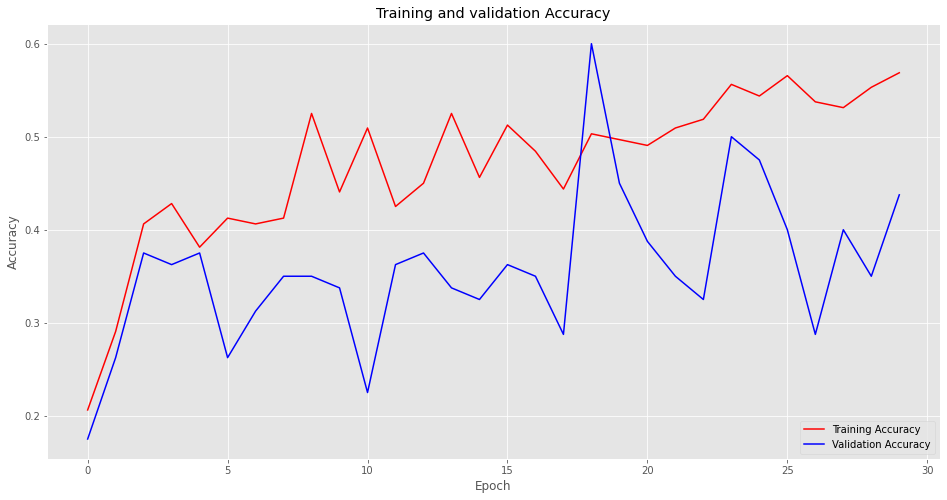

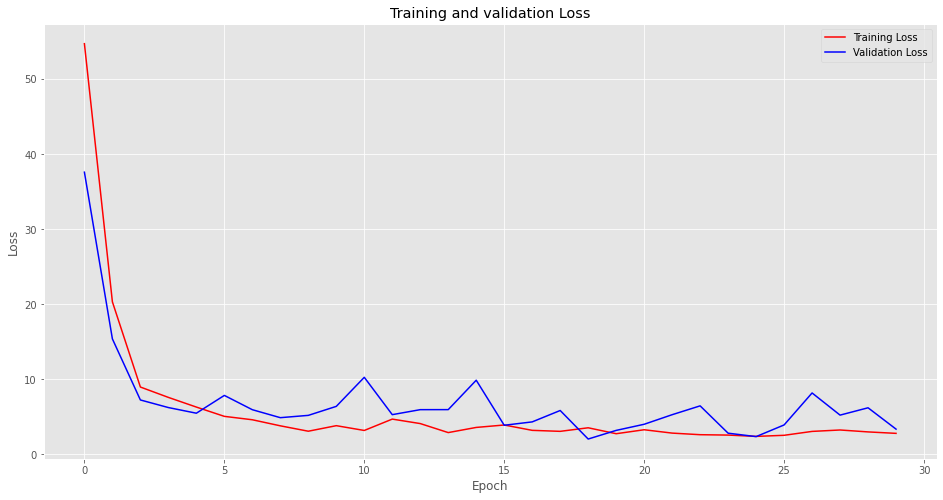

In [ ]:
InceptionV3_Model_acc = InceptionV3_Model_History.history['accuracy']
InceptionV3_Model_val_acc = InceptionV3_Model_History.history['val_accuracy']
InceptionV3_Model_loss = InceptionV3_Model_History.history['loss']
InceptionV3_Model_val_loss = InceptionV3_Model_History.history['val_loss']
epochs = range(len(InceptionV3_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, InceptionV3_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, InceptionV3_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, InceptionV3_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, InceptionV3_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
result = InceptionV3_Model.predict(test_data2)
InceptionV3_Model_y_predict = np.array([i.argmax() for i in result])

InceptionV3_Model_cm = confusion_matrix(y_test, InceptionV3_Model_y_predict)
InceptionV3_Model_ac = accuracy_score(y_test,InceptionV3_Model_y_predict)

print("confusion matrix on test data :\n",InceptionV3_Model_cm)
print("accuracy score on test data:\n",InceptionV3_Model_ac)

print(classification_report(y_test, InceptionV3_Model_y_predict))

confusion matrix on test data :
 [[ 0  5  3 11  1]
 [ 0  6  2  8  4]
 [ 0  1  6  9  4]
 [ 0  2  0 14  4]
 [ 0  1  0  6 13]]
accuracy score on test data:
 0.39
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.40      0.30      0.34        20
           2       0.55      0.30      0.39        20
           3       0.29      0.70      0.41        20
           4       0.50      0.65      0.57        20

    accuracy                           0.39       100
   macro avg       0.35      0.39      0.34       100
weighted avg       0.35      0.39      0.34       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### InceptionResNetV2

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
    classifier_activation="softmax",
)
pretrained_model.trainable = False
InceptionResNetV2_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
InceptionResNetV2_Model.summary()

219070464/219055592 [==============================] - 1s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_9 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_8 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_18 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_19 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                     

#### Model Creation and Training

In [ ]:
InceptionResNetV2_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
InceptionResNetV2_Model_History = InceptionResNetV2_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

Epoch 1/30
10/10 [==============================] - 20s 764ms/step - loss: 743.7419 - accuracy: 0.2062 - val_loss: 275.1265 - val_accuracy: 0.2000
Epoch 2/30
10/10 [==============================] - 4s 329ms/step - loss: 330.1859 - accuracy: 0.2188 - val_loss: 314.4265 - val_accuracy: 0.2000
Epoch 3/30
10/10 [==============================] - 5s 337ms/step - loss: 204.4372 - accuracy: 0.2344 - val_loss: 257.7221 - val_accuracy: 0.2125
Epoch 4/30
10/10 [==============================] - 4s 334ms/step - loss: 319.2381 - accuracy: 0.2219 - val_loss: 323.4471 - val_accuracy: 0.1500
Epoch 5/30
10/10 [==============================] - 5s 333ms/step - loss: 260.3989 - accuracy: 0.2313 - val_loss: 259.7962 - val_accuracy: 0.1625
Epoch 6/30
10/10 [==============================] - 5s 363ms/step - loss: 291.1075 - accuracy: 0.2750 - val_loss: 138.8197 - val_accuracy: 0.2625
Epoch 7/30
10/10 [==============================] - 4s 332ms/step - loss: 184.2201 - accuracy: 0.2344 - val_loss: 110.5976 

#### Accuracy and Loss Curves

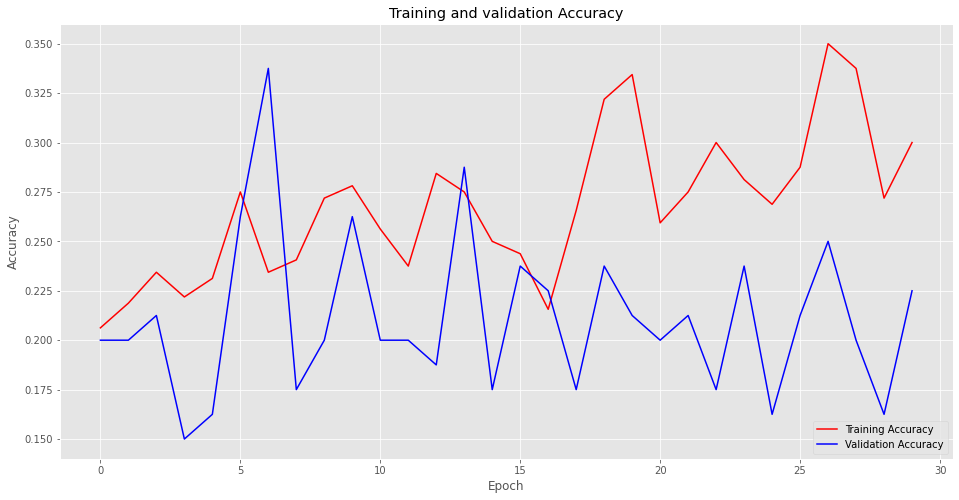

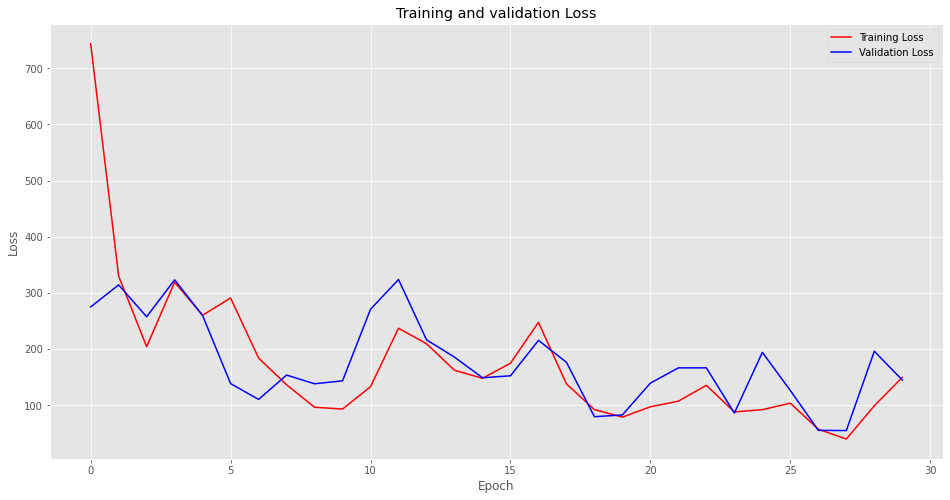

In [ ]:
InceptionResNetV2_Model_acc = InceptionResNetV2_Model_History.history['accuracy']
InceptionResNetV2_Model_val_acc = InceptionResNetV2_Model_History.history['val_accuracy']
InceptionResNetV2_Model_loss = InceptionResNetV2_Model_History.history['loss']
InceptionResNetV2_Model_val_loss = InceptionResNetV2_Model_History.history['val_loss']
epochs = range(len(InceptionResNetV2_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, InceptionResNetV2_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, InceptionResNetV2_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, InceptionResNetV2_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, InceptionResNetV2_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data

In [ ]:
result = InceptionResNetV2_Model.predict(test_data2)
InceptionResNetV2_Model_y_predict = np.array([i.argmax() for i in result])

InceptionResNetV2_Model_cm = confusion_matrix(y_test, InceptionResNetV2_Model_y_predict)
InceptionResNetV2_Model_ac = accuracy_score(y_test,InceptionResNetV2_Model_y_predict)

print("confusion matrix on test data :\n",InceptionResNetV2_Model_cm)
print("accuracy score on test data:\n",InceptionResNetV2_Model_ac)

print(classification_report(y_test, InceptionResNetV2_Model_y_predict))

confusion matrix on test data :
 [[ 0  1 16  3  0]
 [ 0  0 17  3  0]
 [ 0  1 18  1  0]
 [ 0  0 19  1  0]
 [ 0  3 14  3  0]]
accuracy score on test data:
 0.19
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       0.21      0.90      0.35        20
           3       0.09      0.05      0.06        20
           4       0.00      0.00      0.00        20

    accuracy                           0.19       100
   macro avg       0.06      0.19      0.08       100
weighted avg       0.06      0.19      0.08       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Comparing Pre-Trained Models

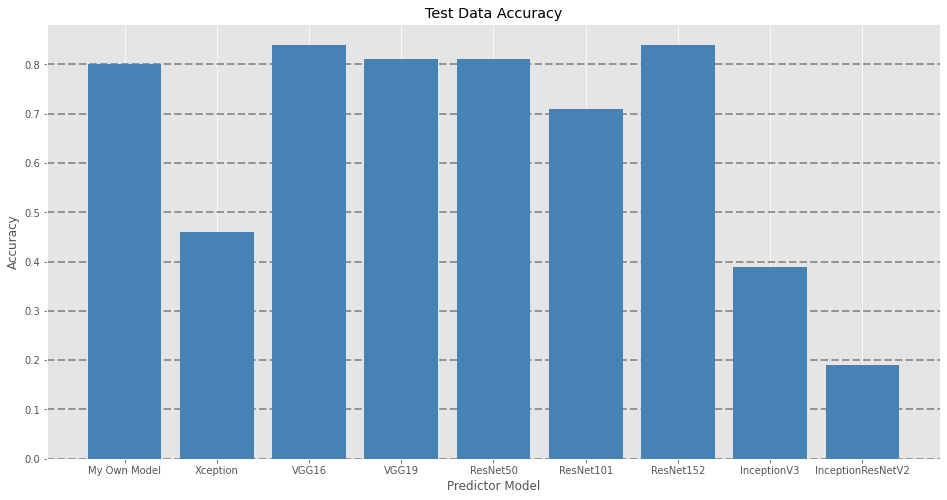

In [ ]:
Models_Names = ["My Own Model", "Xception", "VGG16", "VGG19",
                "ResNet50", "ResNet101", "ResNet152",
                "InceptionV3", "InceptionResNetV2"]
Models_test_acc = [MyOwnModel_ac, Xception_Model_ac, VGG16_Model_ac, VGG19_Model_ac,
                   ResNet50_Model_ac, ResNet101_Model_ac, ResNet152_Model_ac,
                   InceptionV3_Model_ac, InceptionResNetV2_Model_ac]

fig = plt.figure(figsize=(16,8))
plt.bar(Models_Names, Models_test_acc, color='steelblue')
plt.grid(color='gray', linestyle='--', linewidth=2, axis='y', alpha=0.8)
plt.xlabel('Predictor Model')
plt.ylabel('Accuracy')
plt.title('Test Data Accuracy')
plt.show()

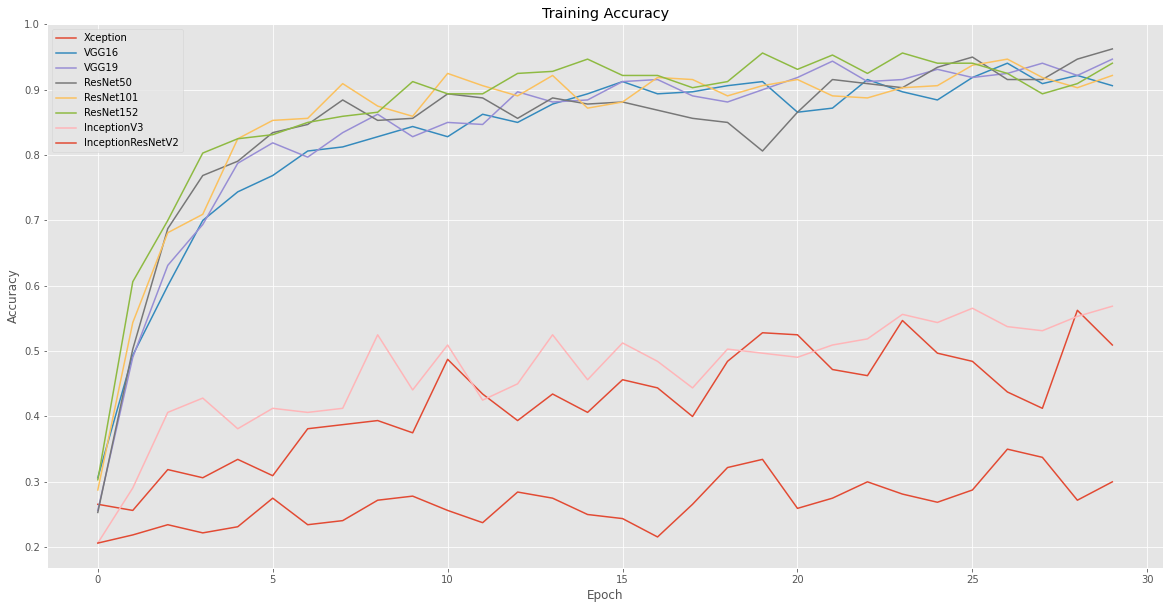

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, Xception_Model_acc, label="Xception")
plt.plot(epochs, VGG16_Model_acc, label="VGG16")
plt.plot(epochs, VGG19_Model_acc, label="VGG19")
plt.plot(epochs, ResNet50_Model_acc, label="ResNet50")
plt.plot(epochs, ResNet101_Model_acc, label="ResNet101")
plt.plot(epochs, ResNet152_Model_acc, label="ResNet152")
plt.plot(epochs, InceptionV3_Model_acc, label="InceptionV3")
plt.plot(epochs, InceptionResNetV2_Model_acc, label="InceptionResNetV2")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend(loc='upper left')
plt.show()

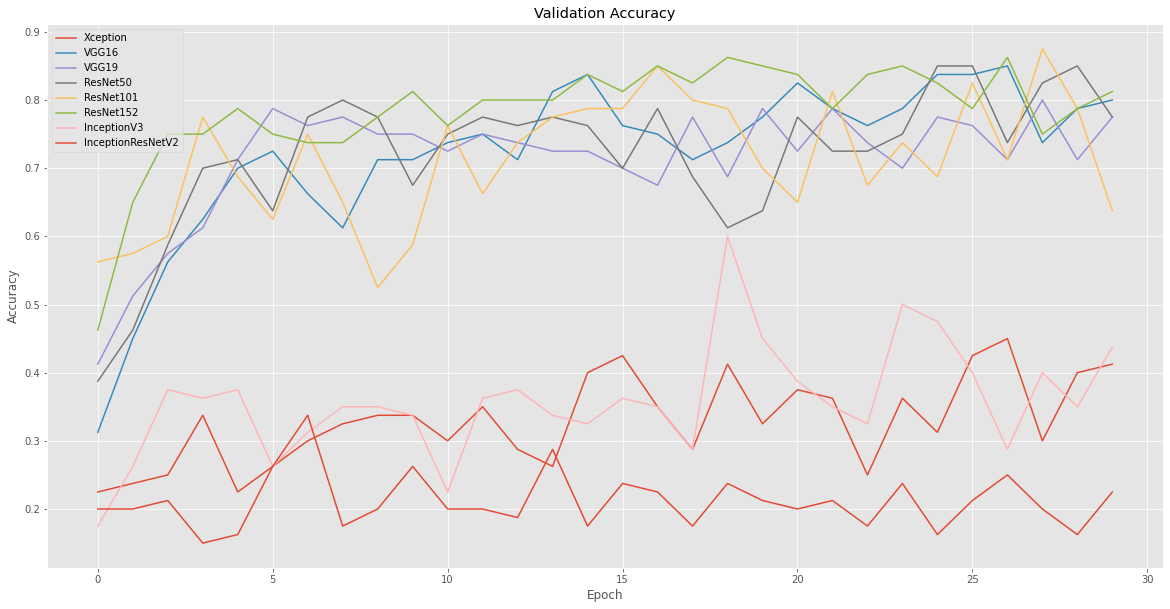

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, Xception_Model_val_acc, label="Xception")
plt.plot(epochs, VGG16_Model_val_acc, label="VGG16")
plt.plot(epochs, VGG19_Model_val_acc, label="VGG19")
plt.plot(epochs, ResNet50_Model_val_acc, label="ResNet50")
plt.plot(epochs, ResNet101_Model_val_acc, label="ResNet101")
plt.plot(epochs, ResNet152_Model_val_acc, label="ResNet152")
plt.plot(epochs, InceptionV3_Model_val_acc, label="InceptionV3")
plt.plot(epochs, InceptionResNetV2_Model_val_acc, label="InceptionResNetV2")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

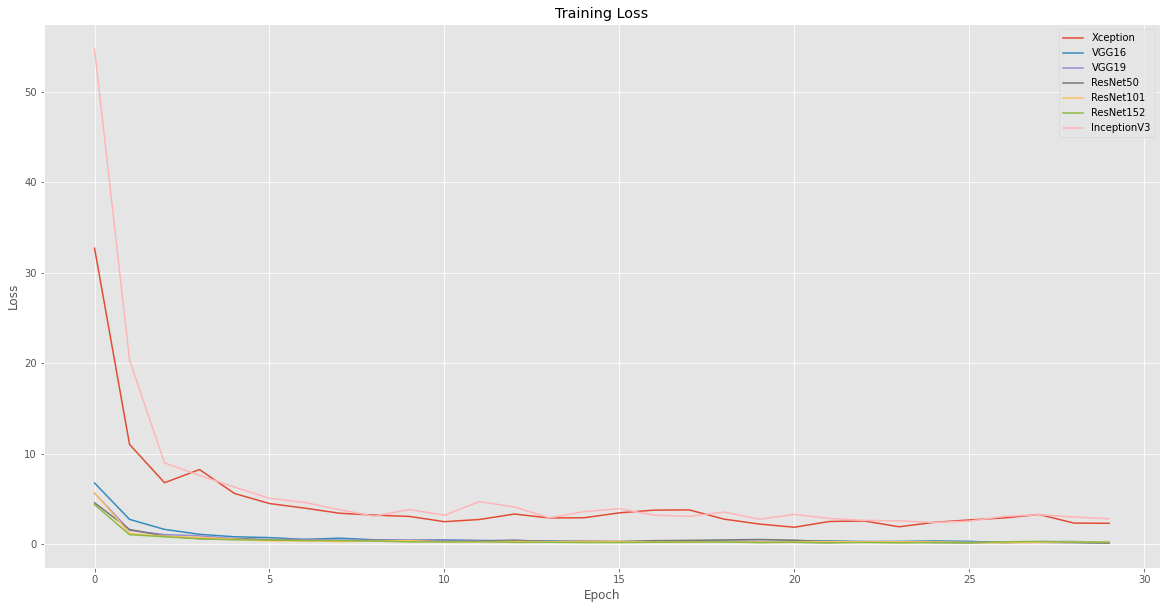

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, Xception_Model_loss, label="Xception")
plt.plot(epochs, VGG16_Model_loss, label="VGG16")
plt.plot(epochs, VGG19_Model_loss, label="VGG19")
plt.plot(epochs, ResNet50_Model_loss, label="ResNet50")
plt.plot(epochs, ResNet101_Model_loss, label="ResNet101")
plt.plot(epochs, ResNet152_Model_loss, label="ResNet152")
plt.plot(epochs, InceptionV3_Model_loss, label="InceptionV3")
#plt.plot(epochs, InceptionResNetV2_Model_loss, label="InceptionResNetV2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(loc='upper right')
plt.show()

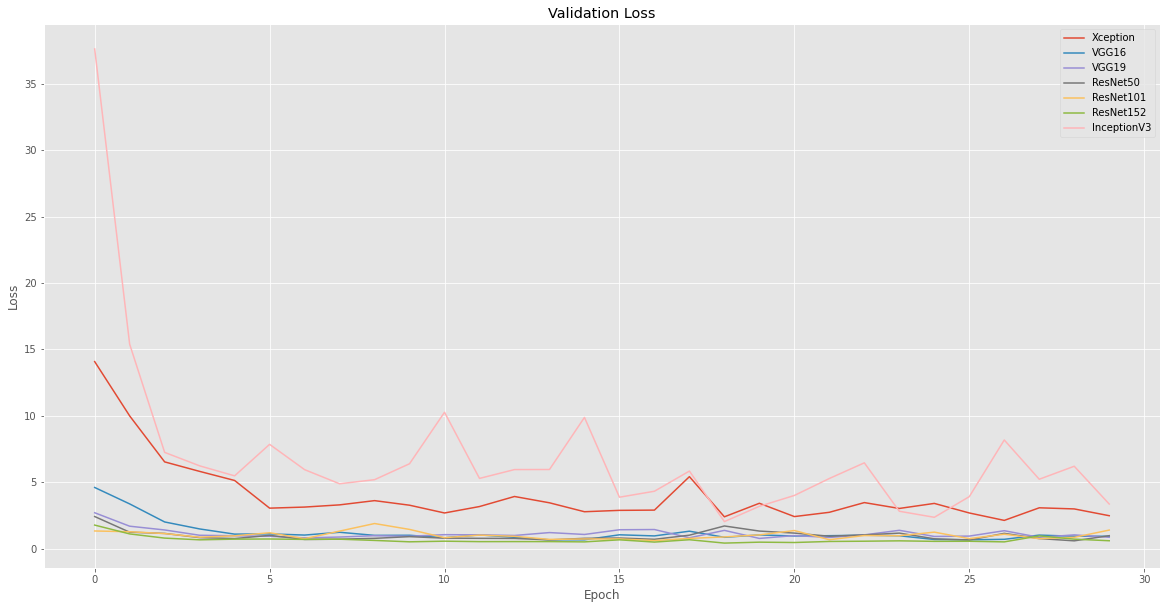

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, Xception_Model_val_loss, label="Xception")
plt.plot(epochs, VGG16_Model_val_loss, label="VGG16")
plt.plot(epochs, VGG19_Model_val_loss, label="VGG19")
plt.plot(epochs, ResNet50_Model_val_loss, label="ResNet50")
plt.plot(epochs, ResNet101_Model_val_loss, label="ResNet101")
plt.plot(epochs, ResNet152_Model_val_loss, label="ResNet152")
plt.plot(epochs, InceptionV3_Model_val_loss, label="InceptionV3")
#plt.plot(epochs, InceptionResNetV2_Model_val_loss, label="InceptionResNetV2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend(loc='upper right')
plt.show()

## Exploiting Autoencoder Networks

### Denoising Autoencoder

#### Noisy Data Generation

In [ ]:
Noise_Factor = 0.3
Noise_Mean = 0.5 * 255

train_data_denoising = augmented_train_data.map(lambda x, y: (x + Noise_Factor * np.random.normal(loc=Noise_Mean, scale=1.0, size=image_size + (3,)), x))
validation_data_denoising = validation_data2.map(lambda x, y: (x + Noise_Factor * np.random.normal(loc=Noise_Mean, scale=1.0, size=image_size + (3,)), x))
test_data_denoising = test_data2.map(lambda x, y: (x + Noise_Factor * np.random.normal(loc=Noise_Mean, scale=1.0, size=image_size + (3,)), x))

##### Random Sample

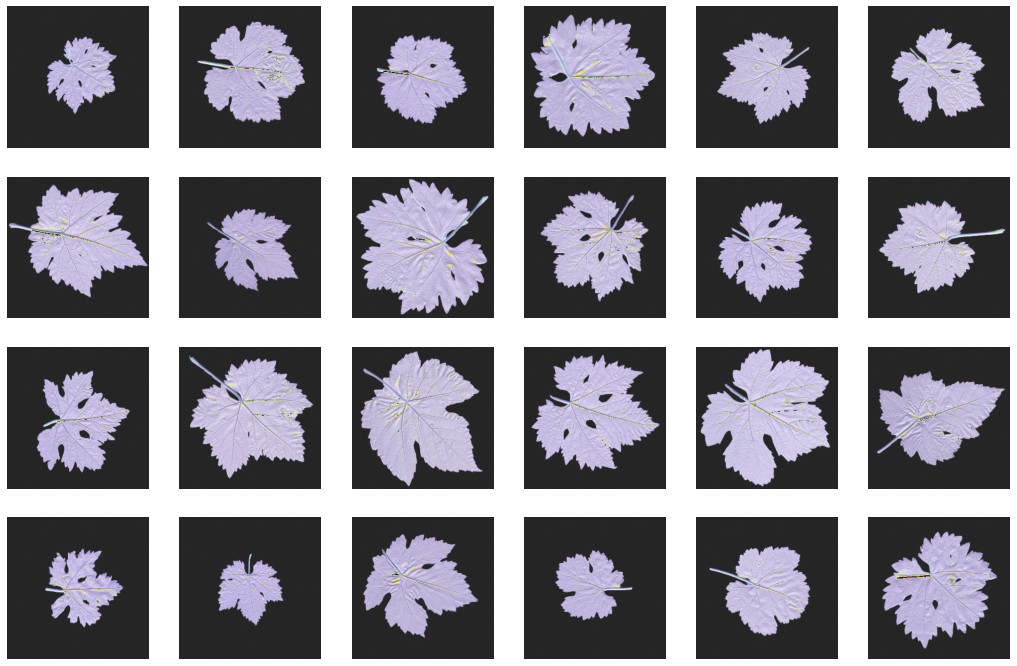

In [ ]:
plt.figure(figsize=(18, 12))
for images, labels in train_data_denoising.take(1):
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

#### Model Architecture Define

In [ ]:
Denoising_Model = keras.models.Sequential([
    layers.Input(shape = image_size + (3,)),
    
    layers.Conv2D(16, (3, 3), activation='relu', padding="same"), 
    layers.MaxPooling2D((2, 2), strides = (2, 2), padding="same"),

    layers.Conv2D(32, (3, 3), activation='relu', padding="same"), 
    layers.MaxPooling2D((2, 2), strides = (2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), activation='relu', padding="same"), 
    layers.MaxPooling2D((2, 2), strides = (2, 2), padding="same"),

    layers.Conv2D(128, (3, 3), activation='relu', padding="same"), 
    layers.MaxPooling2D((2, 2), strides = (2, 2), padding="same"),

    layers.Conv2D(256, (3, 3), activation='relu', padding="same"), 
    layers.MaxPooling2D((2, 2), strides = (2, 2), padding="same"),

    layers.Conv2DTranspose(256, (3, 3), strides = 2, activation="relu", padding="same"),

    layers.Conv2DTranspose(128, (3, 3), strides = 2, activation="relu", padding="same"),

    layers.Conv2DTranspose(64, (3, 3), strides = 2, activation="relu", padding="same"),

    layers.Conv2DTranspose(32, (3, 3), strides = 2, activation="relu", padding="same"),

    layers.Conv2DTranspose(16, (3, 3), strides = 2, activation="relu", padding="same"),

    layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same"),
    layers.Rescaling(scale = 255.0/1, offset = 0.0)
    ])
Denoising_Model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_307 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_308 (Conv2D)         (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_309 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 64)     

#### Model Creation and Training

In [ ]:
Denoising_Model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=["accuracy"],
)
history_Denosing = Denoising_Model.fit(
    train_data_denoising,
    epochs=30,
    validation_data=validation_data_denoising)
Denoising_Model.save('Denoising_Model.h5')

Epoch 1/30
50/50 [==============================] - 30s 542ms/step - loss: 4413.0879 - accuracy: 0.4556 - val_loss: 1178.0547 - val_accuracy: 0.5117
Epoch 2/30
50/50 [==============================] - 27s 521ms/step - loss: 1073.6954 - accuracy: 0.5086 - val_loss: 993.3887 - val_accuracy: 0.5037
Epoch 3/30
50/50 [==============================] - 26s 516ms/step - loss: 911.5294 - accuracy: 0.4822 - val_loss: 915.3781 - val_accuracy: 0.5091
Epoch 4/30
50/50 [==============================] - 27s 519ms/step - loss: 844.0463 - accuracy: 0.5037 - val_loss: 842.1885 - val_accuracy: 0.5345
Epoch 5/30
50/50 [==============================] - 27s 520ms/step - loss: 774.7308 - accuracy: 0.5139 - val_loss: 783.4803 - val_accuracy: 0.5221
Epoch 6/30
50/50 [==============================] - 26s 514ms/step - loss: 1369.8470 - accuracy: 0.7053 - val_loss: 1021.9681 - val_accuracy: 0.8141
Epoch 7/30
50/50 [==============================] - 27s 522ms/step - loss: 899.9434 - accuracy: 0.7895 - val_loss

#### Model Performance Evaluation on Test Data

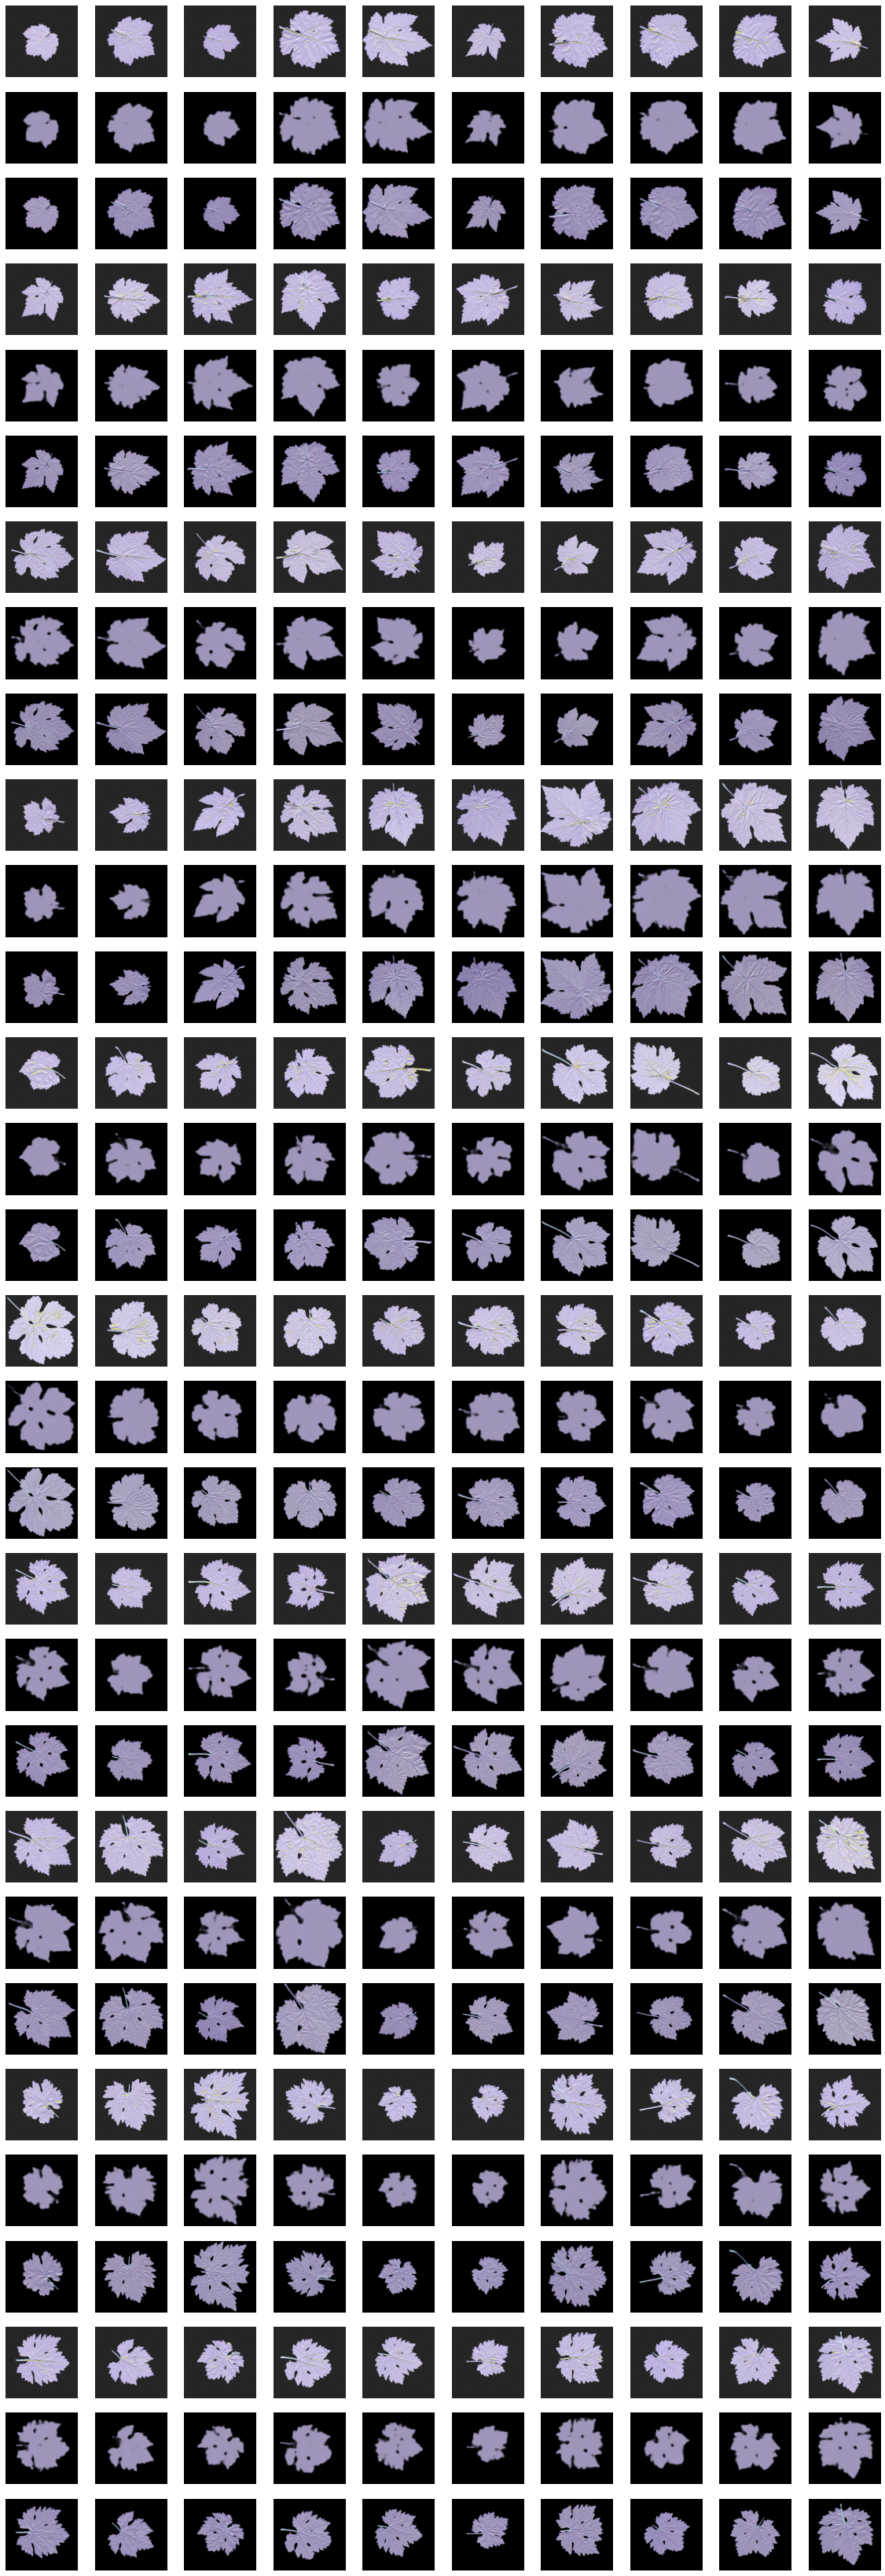

In [ ]:
Denoising_Output = Denoising_Model.predict(test_data_denoising).round()

plt.figure(figsize=(20, 60))
for images, labels in test_data_denoising:
  for rows in range(10):
    for i in range(10):
      ax = plt.subplot(30, 10, rows*30 + i + 1)
      plt.imshow(images[rows*10+i].numpy().astype("uint8"))
      plt.axis("off")
      ax = plt.subplot(30, 10, rows*30 + 10 + i + 1)
      plt.imshow(Denoising_Output[rows*10+i].astype("uint8"))
      plt.axis("off")
      ax = plt.subplot(30, 10, rows*30 + 20 + i + 1)
      plt.imshow(labels[rows*10+i].numpy().astype("uint8"))
      plt.axis("off")

#### Denosing and Classifier Models Merging

##### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
)

Denoising_Model.trainable = False
pretrained_model.trainable = False

Denoised_ResNet152_Model = keras.models.Sequential([
    layers.Input(shape = image_size + (3,)),
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    Denoising_Model,
    pretrained_model, 
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')])

Denoised_ResNet152_Model.summary() 

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_23 (RandomR  (None, 256, 256, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_22 (RandomZoom)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_46 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_47 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 sequential_10 (Sequential)  (None, 256, 256, 3)       1375043   
                                                                 
 resnet152 (Functional)      (None, 8, 8, 2048)        58370944  
                                                     

##### Model Creation and Training

In [ ]:
Denoised_ResNet152_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
Denoised_ResNet152_Model_History = Denoised_ResNet152_Model.fit(
    train_data2,
    epochs = 100,
    validation_data = validation_data2)
Denoised_ResNet152_Model.save('Denoised_ResNet152_Model.h5')

Epoch 1/100
10/10 [==============================] - 19s 888ms/step - loss: 3.1028 - accuracy: 0.2719 - val_loss: 1.9223 - val_accuracy: 0.3125
Epoch 2/100
10/10 [==============================] - 6s 532ms/step - loss: 1.4811 - accuracy: 0.4469 - val_loss: 1.8134 - val_accuracy: 0.3250
Epoch 3/100
10/10 [==============================] - 6s 531ms/step - loss: 1.3274 - accuracy: 0.5125 - val_loss: 1.8741 - val_accuracy: 0.4250
Epoch 4/100
10/10 [==============================] - 6s 529ms/step - loss: 1.3100 - accuracy: 0.5094 - val_loss: 1.2628 - val_accuracy: 0.4875
Epoch 5/100
10/10 [==============================] - 6s 530ms/step - loss: 1.1895 - accuracy: 0.5250 - val_loss: 1.3651 - val_accuracy: 0.4750
Epoch 6/100
10/10 [==============================] - 7s 541ms/step - loss: 1.0632 - accuracy: 0.6125 - val_loss: 1.1749 - val_accuracy: 0.4625
Epoch 7/100
10/10 [==============================] - 6s 539ms/step - loss: 1.0723 - accuracy: 0.6031 - val_loss: 1.1085 - val_accuracy: 0.575

##### Accuracy and Loss Curves

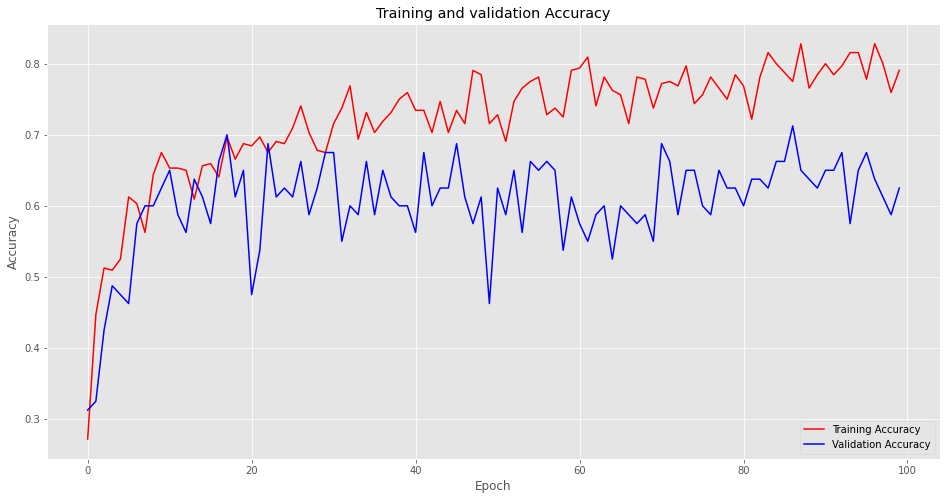

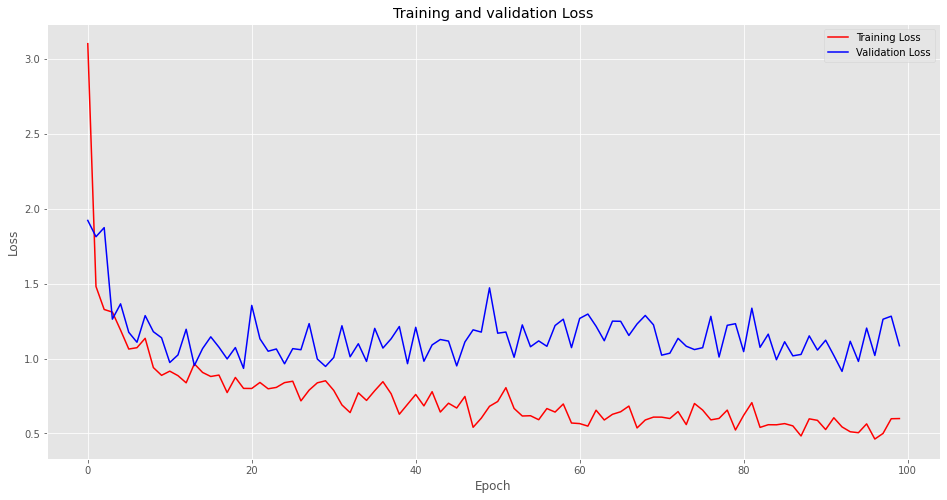

In [ ]:
Denoised_ResNet152_Model_acc = Denoised_ResNet152_Model_History.history['accuracy']
Denoised_ResNet152_Model_val_acc = Denoised_ResNet152_Model_History.history['val_accuracy']
Denoised_ResNet152_Model_loss = Denoised_ResNet152_Model_History.history['loss']
Denoised_ResNet152_Model_val_loss = Denoised_ResNet152_Model_History.history['val_loss']
epochs = range(len(Denoised_ResNet152_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, Denoised_ResNet152_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, Denoised_ResNet152_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, Denoised_ResNet152_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, Denoised_ResNet152_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

##### Model Performance Evaluation on Test Data

In [ ]:
result = Denoised_ResNet152_Model.predict(test_data2)
Denoised_ResNet152_Model_y_predict = np.array([i.argmax() for i in result])

Denoised_ResNet152_Model_cm = confusion_matrix(y_test, Denoised_ResNet152_Model_y_predict)
Denoised_ResNet152_Model_ac = accuracy_score(y_test,Denoised_ResNet152_Model_y_predict)

print("confusion matrix on test data :\n",Denoised_ResNet152_Model_cm)
print("accuracy score on test data:\n",Denoised_ResNet152_Model_ac)

print(classification_report(y_test, Denoised_ResNet152_Model_y_predict))

confusion matrix on test data :
 [[ 9  1  2  3  5]
 [ 3  9  1  3  4]
 [ 0  2 11  6  1]
 [ 0  0  1 19  0]
 [ 0  0  0  4 16]]
accuracy score on test data:
 0.64
              precision    recall  f1-score   support

           0       0.75      0.45      0.56        20
           1       0.75      0.45      0.56        20
           2       0.73      0.55      0.63        20
           3       0.54      0.95      0.69        20
           4       0.62      0.80      0.70        20

    accuracy                           0.64       100
   macro avg       0.68      0.64      0.63       100
weighted avg       0.68      0.64      0.63       100



### Dimension Reduction Autoencoder

#### Input Dataset Generation

In [ ]:
train_data_dimension_reduction = augmented_train_data.map(lambda x, y: (x, x))
validation_data_dimension_reduction = validation_data2.map(lambda x, y: (x, x))
test_data_dimension_reduction = test_data2.map(lambda x, y: (x, x))

#### Model Architecture Define

In [ ]:
Encoder_Model = keras.models.Sequential([
    layers.Resizing(128, 128),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
])
Decoder_Model = keras.models.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(128*128*3, activation='relu'),
    layers.Reshape((128,128,3)),
    layers.Resizing(256, 256),
    ])
AutoEncoder_Model = keras.models.Sequential([
    layers.Input(shape = image_size + (3,)),
    Encoder_Model,
    Decoder_Model,
    ])
AutoEncoder_Model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 256)               25822976  
                                                                 
 sequential_13 (Sequential)  (None, 256, 256, 3)       25871872  
                                                                 
Total params: 51,694,848
Trainable params: 51,694,848
Non-trainable params: 0
_________________________________________________________________


#### Model Creation and Training

In [ ]:
AutoEncoder_Model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["accuracy"])
AutoEncoder_Model_History = AutoEncoder_Model.fit(
    train_data_dimension_reduction,
    epochs = 30,
    validation_data = validation_data_dimension_reduction)
AutoEncoder_Model.save('AutoEncoder_Model.h5')

Epoch 1/30
50/50 [==============================] - 24s 451ms/step - loss: 5494.3774 - accuracy: 0.6457 - val_loss: 1883.8910 - val_accuracy: 0.7509
Epoch 2/30
50/50 [==============================] - 24s 464ms/step - loss: 1962.8203 - accuracy: 0.7794 - val_loss: 1792.2292 - val_accuracy: 0.7901
Epoch 3/30
50/50 [==============================] - 23s 454ms/step - loss: 1953.9180 - accuracy: 0.7910 - val_loss: 1768.0045 - val_accuracy: 0.7962
Epoch 4/30
50/50 [==============================] - 24s 470ms/step - loss: 1879.6384 - accuracy: 0.7955 - val_loss: 1683.2504 - val_accuracy: 0.8001
Epoch 5/30
50/50 [==============================] - 24s 454ms/step - loss: 1820.4648 - accuracy: 0.8069 - val_loss: 1635.9193 - val_accuracy: 0.8063
Epoch 6/30
50/50 [==============================] - 23s 450ms/step - loss: 1766.6345 - accuracy: 0.8141 - val_loss: 1580.8464 - val_accuracy: 0.8155
Epoch 7/30
50/50 [==============================] - 24s 469ms/step - loss: 1695.9198 - accuracy: 0.8210 - 

#### Model Performance Evaluation on Test Data

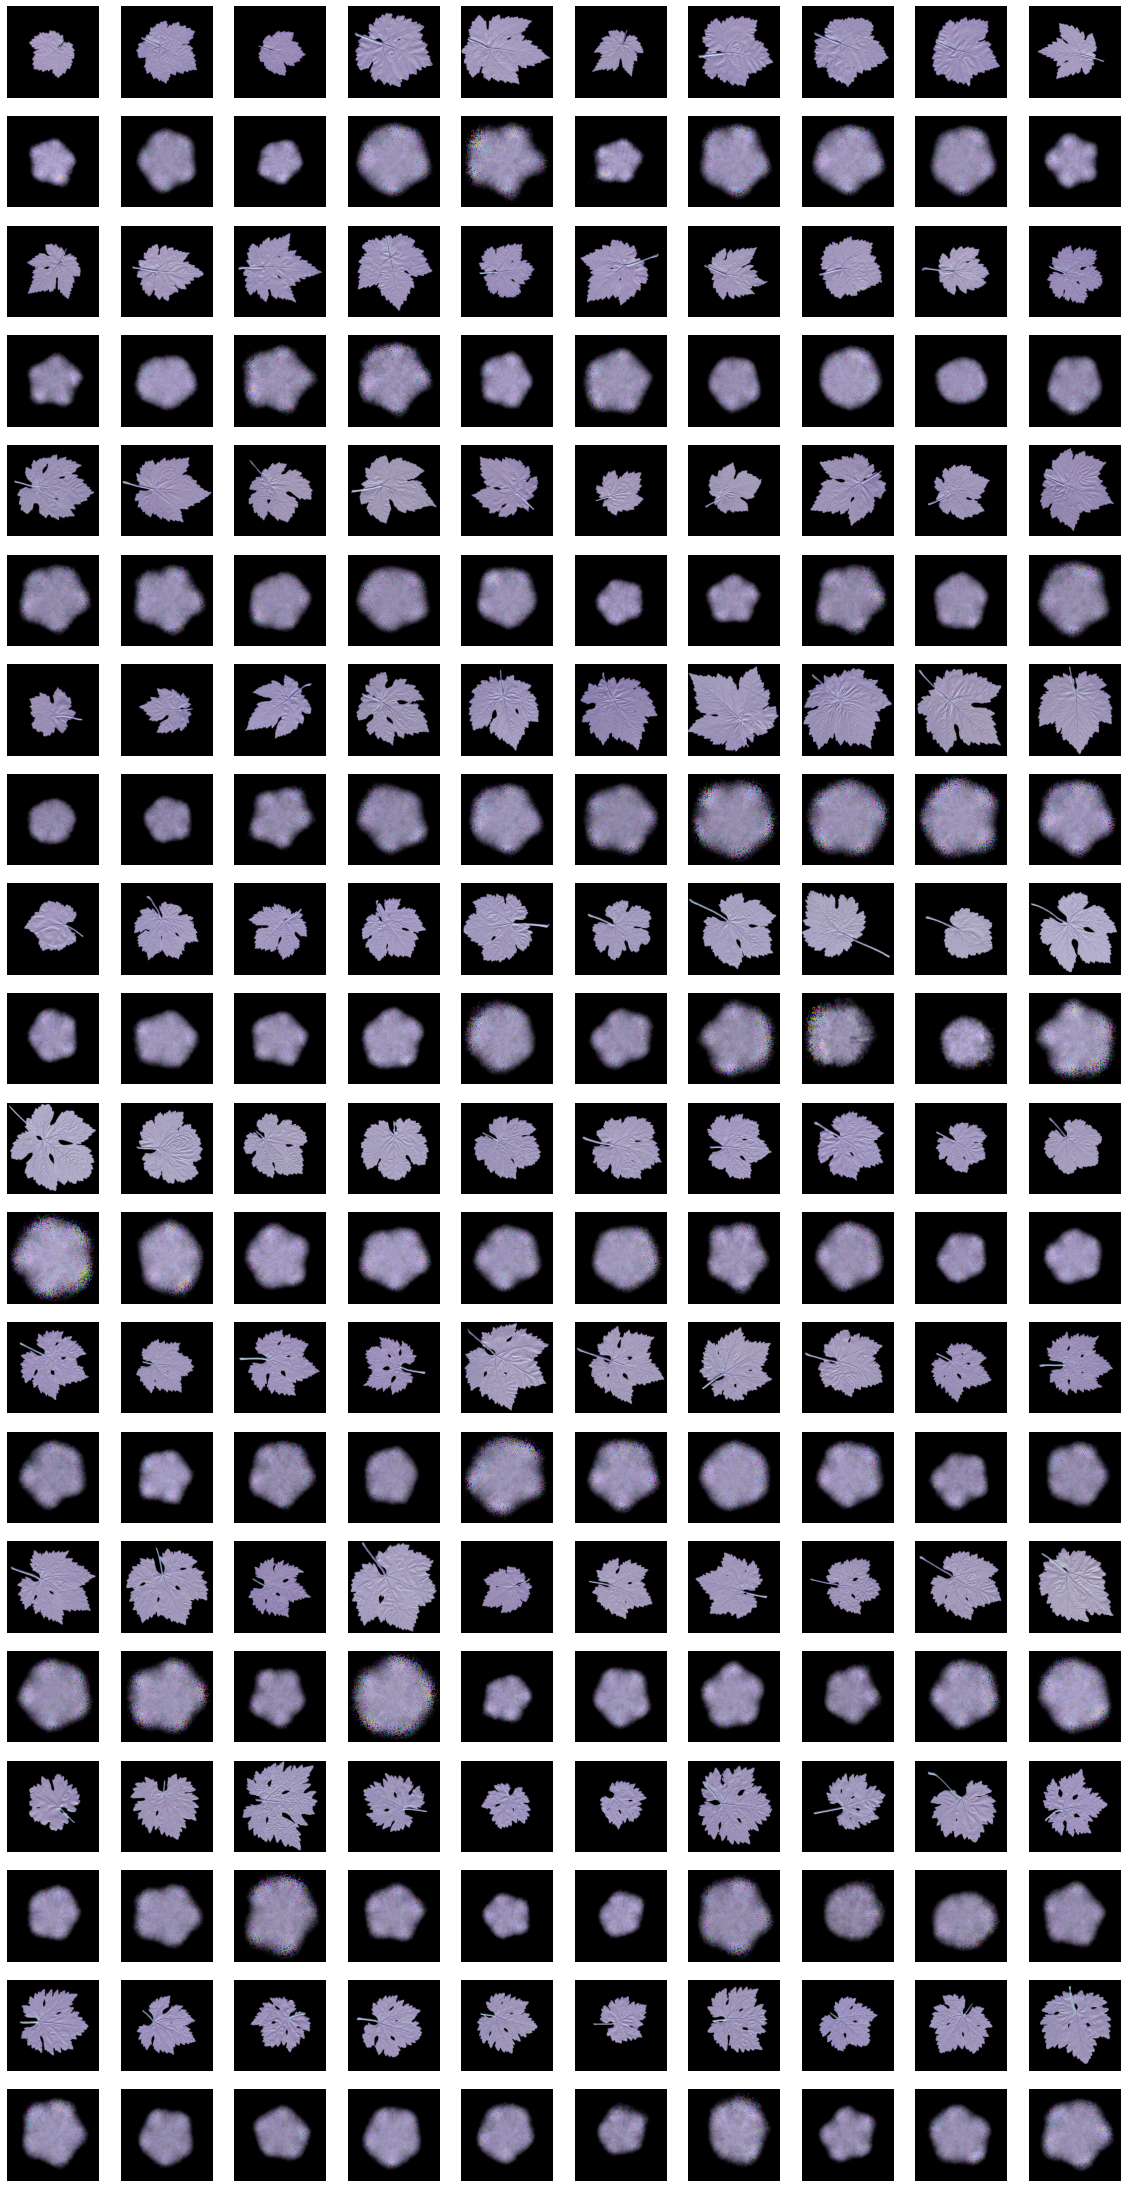

In [ ]:
AutoEncoder_Output = AutoEncoder_Model.predict(test_data_dimension_reduction).round()

plt.figure(figsize=(20, 40))
for images, labels in test_data_dimension_reduction:
  for rows in range(10):
    for i in range(10):
      ax = plt.subplot(20, 10, rows*20 + i + 1)
      plt.imshow(images[rows*10+i].numpy().astype("uint8"))
      plt.axis("off")
      ax = plt.subplot(20, 10, rows*20 + 10 + i + 1)
      plt.imshow(AutoEncoder_Output[rows*10+i].astype("uint8"))
      plt.axis("off")

#### Dimension Reduction and Classifier Models Merging

##### Model Architecture Define

In [ ]:
Encoder_Model.trainable = False

Dimension_Reduction_Model = keras.models.Sequential([
    layers.Input(shape = image_size + (3,)),
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    Encoder_Model,
    layers.Dense(512, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(2048, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
    ])

Dimension_Reduction_Model.summary() 

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_11 (RandomR  (None, 256, 256, 3)      0         
 otation)                                                        
                                                                 
 random_zoom_10 (RandomZoom)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_22 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_23 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 sequential_12 (Sequential)  (None, 256)               25822976  
                                                                 
 dense_41 (Dense)            (None, 512)               131584    
                                                     

##### Model Creation and Training

In [ ]:
Dimension_Reduction_Model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
Dimension_Reduction_Model_History = Dimension_Reduction_Model.fit(
    train_data2,
    epochs = 100,
    validation_data = validation_data2)
Dimension_Reduction_Model.save('Dimension_Reduction_Model.h5')

Epoch 1/100
10/10 [==============================] - 4s 93ms/step - loss: 231.9106 - accuracy: 0.2000 - val_loss: 41.0477 - val_accuracy: 0.1625
Epoch 2/100
10/10 [==============================] - 2s 78ms/step - loss: 19.2197 - accuracy: 0.1875 - val_loss: 3.7713 - val_accuracy: 0.2500
Epoch 3/100
10/10 [==============================] - 2s 79ms/step - loss: 2.9809 - accuracy: 0.2438 - val_loss: 1.9665 - val_accuracy: 0.2750
Epoch 4/100
10/10 [==============================] - 3s 119ms/step - loss: 1.8545 - accuracy: 0.2188 - val_loss: 1.6402 - val_accuracy: 0.3250
Epoch 5/100
10/10 [==============================] - 2s 78ms/step - loss: 1.6852 - accuracy: 0.2250 - val_loss: 1.6159 - val_accuracy: 0.3375
Epoch 6/100
10/10 [==============================] - 2s 75ms/step - loss: 1.6689 - accuracy: 0.2438 - val_loss: 1.6125 - val_accuracy: 0.2500
Epoch 7/100
10/10 [==============================] - 2s 78ms/step - loss: 1.6157 - accuracy: 0.2469 - val_loss: 1.6241 - val_accuracy: 0.2500
E

##### Accuracy and Loss Curves

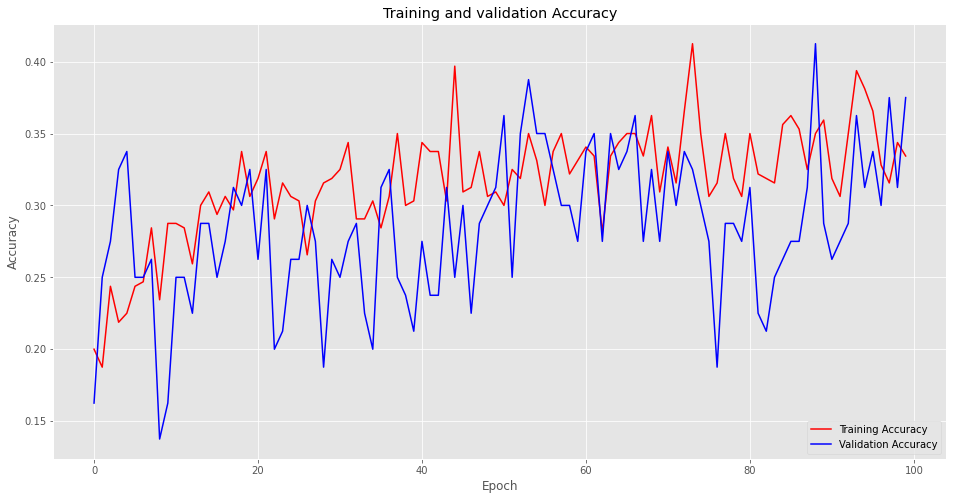

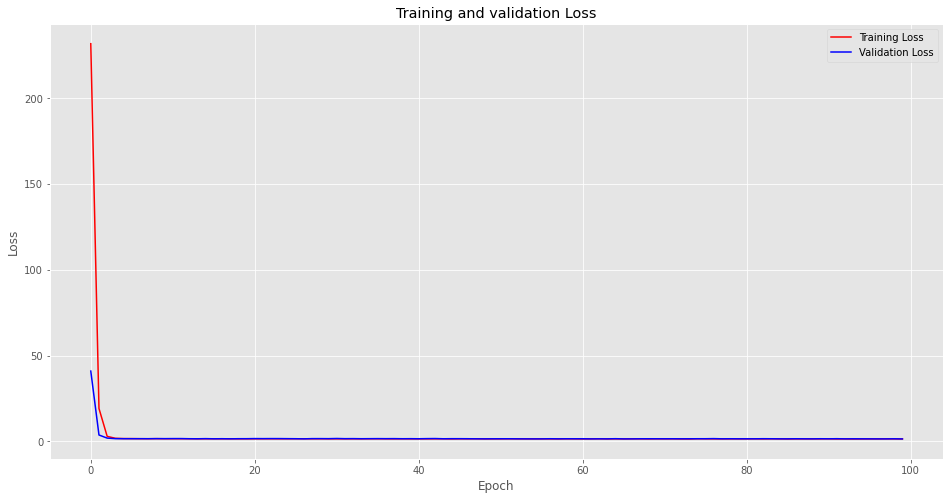

In [ ]:
Dimension_Reduction_Model_acc = Dimension_Reduction_Model_History.history['accuracy']
Dimension_Reduction_Model_val_acc = Dimension_Reduction_Model_History.history['val_accuracy']
Dimension_Reduction_Model_loss = Dimension_Reduction_Model_History.history['loss']
Dimension_Reduction_Model_val_loss = Dimension_Reduction_Model_History.history['val_loss']
epochs = range(len(Dimension_Reduction_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, Dimension_Reduction_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, Dimension_Reduction_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, Dimension_Reduction_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, Dimension_Reduction_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

##### Model Performance Evaluation on Test Data

In [ ]:
result = Dimension_Reduction_Model.predict(test_data2)
Dimension_Reduction_Model_y_predict = np.array([i.argmax() for i in result])

Dimension_Reduction_Model_cm = confusion_matrix(y_test, Dimension_Reduction_Model_y_predict)
Dimension_Reduction_Model_ac = accuracy_score(y_test,Dimension_Reduction_Model_y_predict)

print("confusion matrix on test data :\n",Dimension_Reduction_Model_cm)
print("accuracy score on test data:\n",Dimension_Reduction_Model_ac)

print(classification_report(y_test, Dimension_Reduction_Model_y_predict))

confusion matrix on test data :
 [[11  1  3  4  1]
 [ 3  6  1  4  6]
 [ 7  1  4  3  5]
 [ 5  5  1  2  7]
 [ 3  1  1  8  7]]
accuracy score on test data:
 0.3
              precision    recall  f1-score   support

           0       0.38      0.55      0.45        20
           1       0.43      0.30      0.35        20
           2       0.40      0.20      0.27        20
           3       0.10      0.10      0.10        20
           4       0.27      0.35      0.30        20

    accuracy                           0.30       100
   macro avg       0.31      0.30      0.29       100
weighted avg       0.31      0.30      0.29       100



## 10 Different Seeds

In [ ]:
def load_by_conf(seed = 199, image_size = (256,256), batch_size = 32, validation_split = 0.2):
    train_data = tf.keras.utils.image_dataset_from_directory(
        'Grapevine_Leaves_Image_Dataset',
        class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
        batch_size=batch_size,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split,
        subset="training"
    )
    validation_data = tf.keras.utils.image_dataset_from_directory(
        'Grapevine_Leaves_Image_Dataset',
        class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
        batch_size=batch_size,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split,
        subset="validation"
    )
    test_data = tf.keras.utils.image_dataset_from_directory(
        'Test_Data',
        class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
        image_size=image_size,
        batch_size=100,
        shuffle=False,
    )
    train_data_transposed = train_data.map(lambda x, y: (255-x, y))
    validation_data_transposed = validation_data.map(lambda x, y: (255-x, y))
    test_data_transposed = test_data.map(lambda x, y: (255-x, y))
    return([train_data_transposed, validation_data_transposed, test_data_transposed])

In [ ]:
def best_model_train(data, epochs = 2):
    pretrained_model = tf.keras.applications.ResNet152(
        include_top=False, 
        weights="imagenet",
        input_shape=image_size + (3,),
        classes=1000)
    pretrained_model.trainable = False

    Best_Model = tf.keras.Sequential([
        layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
        layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        pretrained_model, layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')])
    Best_Model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"])
    Best_Model_History = Best_Model.fit(
        data[0],
        epochs = epochs,
        validation_data = data[1],
        verbose=2)
    
    result = Best_Model.predict(data[2])
    Best_Model_y_predict = np.array([i.argmax() for i in result])
    y_test = np.concatenate([y for x, y in data[2]], axis=0)
    Best_Model_cm = confusion_matrix(y_test, Best_Model_y_predict)
    Best_Model_ac = accuracy_score(y_test,Best_Model_y_predict)
    res = [Best_Model_ac, Best_Model_cm, classification_report(y_test, Best_Model_y_predict)]
    return(res)

In [ ]:
seeds = [101, 103, 107, 109, 113, 127, 131, 137, 139, 149]
results = []
for s in seeds:
    print("*"*40)
    print("For Seed = ", s)
    print("*"*40)
    new_data = load_by_conf(seed = s)
    new_res = best_model_train(new_data, epochs = 30)
    results.append(new_res)
    print("*"*40)
    print("\n"*2)
accs = []
cfmxs = []
clfrep = []
for i in results:
    accs.append(i[0])
    cfmxs.append(i[1])
    clfrep.append(i[2])

****************************************
For Seed =  101
****************************************
Found 400 files belonging to 5 classes.
Using 320 files for training.
Found 400 files belonging to 5 classes.
Using 80 files for validation.
Found 100 files belonging to 5 classes.
Epoch 1/30
10/10 - 18s - loss: 4.3181 - accuracy: 0.3156 - val_loss: 2.1016 - val_accuracy: 0.4375 - 18s/epoch - 2s/step
Epoch 2/30
10/10 - 6s - loss: 1.3905 - accuracy: 0.5188 - val_loss: 1.1251 - val_accuracy: 0.6250 - 6s/epoch - 623ms/step
Epoch 3/30
10/10 - 6s - loss: 0.8855 - accuracy: 0.7000 - val_loss: 1.0056 - val_accuracy: 0.6750 - 6s/epoch - 582ms/step
Epoch 4/30
10/10 - 6s - loss: 0.6247 - accuracy: 0.7688 - val_loss: 0.8430 - val_accuracy: 0.7125 - 6s/epoch - 580ms/step
Epoch 5/30
10/10 - 7s - loss: 0.4328 - accuracy: 0.8438 - val_loss: 0.7114 - val_accuracy: 0.8000 - 7s/epoch - 675ms/step
Epoch 6/30
10/10 - 7s - loss: 0.4087 - accuracy: 0.8531 - val_loss: 0.8423 - val_accuracy: 0.7500 - 7s/epoch - 7

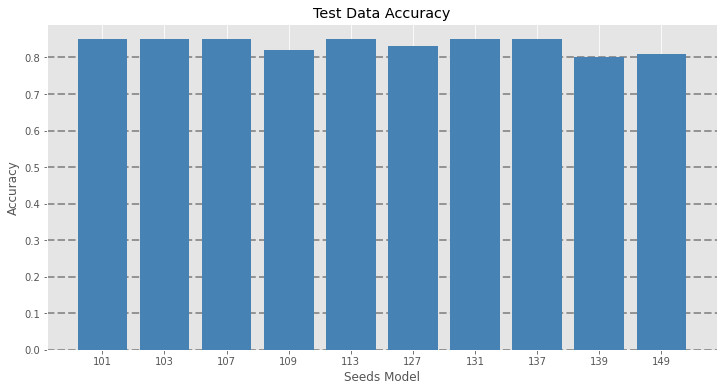

****************************************************************************************************
accuracies :  [0.85, 0.85, 0.85, 0.82, 0.85, 0.83, 0.85, 0.85, 0.8, 0.81]
Mean accuracy :  0.836
Best Model Classification Report :
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        20
           1       1.00      0.80      0.89        20
           2       0.90      0.95      0.93        20
           3       1.00      0.70      0.82        20
           4       0.82      0.90      0.86        20

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



In [ ]:
fig = plt.figure(figsize=(12,6))
plt.bar([str(i) for i in seeds], accs, color='steelblue')
plt.grid(color='gray', linestyle='--', linewidth=2, axis='y', alpha=0.8)
plt.xlabel('Seeds Model')
plt.ylabel('Accuracy')
plt.title('Test Data Accuracy')
plt.show()
print("*"*100)
print("accuracies : ", accs)
print("Mean accuracy : ",np.array(accs).mean())
print("Best Model Classification Report :")
print(clfrep[np.array(accs).argmax()])